# `AVDOS-VR` - Virtual Reality Affective Video Database with Physiological Signals

Check `1_preprocess...ipynb` to see details on how to use the scripts to generate a preprocessed dataset compatible with this notebook.

This notebook takes a single postprocessed file `Dataset_AVDOSVR_full_postprocessed.csv` to generate the statistical analysis and feature-based classification.

In [1]:
# Add files to sys.path
from pathlib import Path
import sys,os
this_path = None
try:    # WORKS WITH .py
    this_path = str(os.path.dirname(os.path.abspath(__file__)))
except: # WORKS WITH .ipynb
    this_path = str(Path().absolute())+"/" 
print("File Path:", this_path)

# Add the level up to the file path so it recognizes the scripts inside `avdosvr`
sys.path.append(os.path.join(this_path, ".."))

File Path: F:\AVDOS-VR/


In [2]:
# Import classes
import avdosvr.preprocessing       # Generate dataset index, load files, and plots.

# Utils for generation of files and paths
from avdosvr.utils import files_handler

# Import data science libs
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
import seaborn as sns

# Statistical tests
import scipy.stats as stats
from scipy.stats import mannwhitneyu, f_oneway

# Preprocessing
import neurokit2 as nk

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Feature based classification

from sklearn.base import clone
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from lime import lime_tabular

# Evaluation
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Turn off chained assignment warning
pd.options.mode.chained_assignment = None 

---
## Setup

Global variables and functions for file management

In [3]:
### General configuration

# Path to the participants' folder w.r.t this notebook's filepath
DATASET_ROOT_FOLDER = "../data/"

# Used to generate the path of temporary subfolders
NOTEBOOK_NAME = "2_affect"

In [4]:
# Functions to generate filepaths

# MAIN FOLDERS FOR OUTPUT FILES
ROOT = this_path + ""   # Root folder for all the files w.r.t this file
TEMP_FOLDER = ROOT+"temp/"  # Main folder for temp files with intermediate calculations
RESULTS_FOLDER = ROOT+"results/"    # Folder to recreate plots and results from analyses

EXPORT_PLOTS = True
IMG_FORMAT = ".pdf"

# Generates paths for files created from this script

def gen_path_plot(filename, extension=IMG_FORMAT):
    # Generates full paths for PLOTS just by specifying a name
    return files_handler.generate_complete_path(filename, \
                                        main_folder=RESULTS_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/plots/", \
                                        file_extension=extension, save_files=EXPORT_PLOTS)

def gen_path_temp(filename, extension, subfolders=""):
    # Generates full paths for TEMP FILES just by specifying a name
    return files_handler.generate_complete_path(filename, \
                                        main_folder=TEMP_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/"+subfolders, \
                                        file_extension=extension)

def gen_path_results(filename, subfolders="", extension=""):
    # Generates full paths for RESULTS FILES (like pandas dataframes)
    return files_handler.generate_complete_path(filename, \
                                        main_folder=RESULTS_FOLDER, \
                                        subfolders=NOTEBOOK_NAME+"/"+subfolders, \
                                        file_extension=extension)

---

## Analysis 1: Validation of Subjective Self-reported Measures

### Plotting Valence-Arousal ratings per video across all data from participants

*Conclusion from statistical tests and plot:*
- It shows how the video categories: `Negative` and `Positive` can be discriminated from the Valence component, but not from the arousal. As expected.
- The categories in Valence may be used as ground-truth for the ML task. But not the presumed labels in Arousal.

In [5]:
# The preprocessing manager analyzes the original data folder
# to create an index and facilitate preprocessing.
data_loader = avdosvr.preprocessing.Manager(DATASET_ROOT_FOLDER, index_files_path = TEMP_FOLDER)

Index already exists: Loading from  F:\AVDOS-VR/temp/avdosvr_index/avdosvr_tree_index.json
Participant 0 with folder id: 101 was part of protocol: v1
Participant 1 with folder id: 216 was part of protocol: v1
Participant 2 with folder id: 219 was part of protocol: v1
Participant 3 with folder id: 222 was part of protocol: v1
Participant 4 with folder id: 247 was part of protocol: v1
Participant 5 with folder id: 248 was part of protocol: v1
Participant 6 with folder id: 268 was part of protocol: v1
Participant 7 with folder id: 270 was part of protocol: v1
Participant 8 with folder id: 278 was part of protocol: v1
Participant 9 with folder id: 290 was part of protocol: v1
Participant 10 with folder id: 293 was part of protocol: v1
Participant 11 with folder id: 299 was part of protocol: v1
Participant 12 with folder id: 307 was part of protocol: v1
Participant 13 with folder id: 308 was part of protocol: v1
Participant 14 with folder id: 309 was part of protocol: v1
Participant 15 with

In [6]:
# Total participants
participants_ids = data_loader.summary["index_id"].unique()
participants_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36], dtype=int64)

In [7]:
# Total sessions
experiment_segment_names = data_loader.summary["Segment"].unique()
experiment_segment_names

array(['video_1', 'video_2', 'video_3', 'video_4', 'video_5'],
      dtype=object)

In [8]:
# Merge the videoIds to each of the unaltered affective ratings
affect_ratings_matched_video_id = None
for participant in participants_ids:
    # Preparing dataframes to be merged
    df_em = data_loader.emotions[participant]
    df_seg = data_loader.segments[participant].drop("Session",axis=1) # Session is duplicated
    df_seg = df_seg[ df_seg["Trigger"] != "Start"] # To avoid errors when start and end are intertwined
    # Merging
    this_affect_ratings_merged = pd.merge_asof(df_em, df_seg, left_index=True, right_index=True, direction="forward")
    this_affect_ratings_merged.insert(0,"p_index_id",participant)
    this_affect_ratings_merged.insert(1,"participant_id",int(data_loader.index[participant]["participant_id"]))
    
    affect_ratings_matched_video_id = this_affect_ratings_merged if (affect_ratings_matched_video_id is None) else \
                                        pd.concat([affect_ratings_matched_video_id,this_affect_ratings_merged], axis=0, ignore_index=True)

# Show result
MATCHED_AFFECTIVE_RATINGS_FILENAME = gen_path_temp("AffectiveRatingsMatchedVideoId",extension=".csv")
affect_ratings_matched_video_id.to_csv( MATCHED_AFFECTIVE_RATINGS_FILENAME, index=False )

In [9]:
affect_ratings_matched_video_id.isna().sum()

p_index_id          0
participant_id      0
Session             0
Valence             0
Arousal             0
RawX                0
RawY                0
Segment            88
VideoId           371
Trigger            88
dtype: int64

The rows with `VideoId=NaN` mean that an affective ratings was generated outside the valid experimental segments. Valid segments are within the 120s-long resting stage or the 300s-long videos

In [10]:
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
0,0,101,video_1,3,5,94,124,Positive,NaN,StartSegment
1,0,101,video_2,5,5,128,122,Positive,-1.0,End
2,0,101,video_2,6,5,149,127,Positive,-1.0,End
3,0,101,video_2,7,5,170,127,Positive,-1.0,End
4,0,101,video_2,8,5,193,126,Positive,-1.0,End
...,...,...,...,...,...,...,...,...,...,...
38822,36,382,video_5,8,1,179,61,video_5,-1.0,End
38823,36,382,video_5,7,1,178,61,video_5,-1.0,End
38824,36,382,video_5,8,1,179,61,video_5,-1.0,End
38825,36,382,video_5,7,1,178,61,video_5,-1.0,End


In [11]:
affect_ratings_matched_video_id.dropna(axis=0, subset=["VideoId"], inplace=True)
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
1,0,101,video_2,5,5,128,122,Positive,-1.0,End
2,0,101,video_2,6,5,149,127,Positive,-1.0,End
3,0,101,video_2,7,5,170,127,Positive,-1.0,End
4,0,101,video_2,8,5,193,126,Positive,-1.0,End
5,0,101,video_2,7,5,191,125,Positive,-1.0,End
...,...,...,...,...,...,...,...,...,...,...
38822,36,382,video_5,8,1,179,61,video_5,-1.0,End
38823,36,382,video_5,7,1,178,61,video_5,-1.0,End
38824,36,382,video_5,8,1,179,61,video_5,-1.0,End
38825,36,382,video_5,7,1,178,61,video_5,-1.0,End


In [12]:
# Keep the data from affect segments (excluding `video_1`) corresponding to resting stages.
Q = ( (affect_ratings_matched_video_id["Segment"]=="Positive") | \
        (affect_ratings_matched_video_id["Segment"]=="Negative") | \
        (affect_ratings_matched_video_id["Segment"]=="Neutral") | \
        (affect_ratings_matched_video_id["Segment"]=="video_5"))
affect_ratings_matched_video_id = affect_ratings_matched_video_id[ Q ]
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
1,0,101,video_2,5,5,128,122,Positive,-1.0,End
2,0,101,video_2,6,5,149,127,Positive,-1.0,End
3,0,101,video_2,7,5,170,127,Positive,-1.0,End
4,0,101,video_2,8,5,193,126,Positive,-1.0,End
5,0,101,video_2,7,5,191,125,Positive,-1.0,End
...,...,...,...,...,...,...,...,...,...,...
38822,36,382,video_5,8,1,179,61,video_5,-1.0,End
38823,36,382,video_5,7,1,178,61,video_5,-1.0,End
38824,36,382,video_5,8,1,179,61,video_5,-1.0,End
38825,36,382,video_5,7,1,178,61,video_5,-1.0,End


In [13]:
# Replace the resting videoId with text for plot
affect_ratings_matched_video_id = affect_ratings_matched_video_id.astype({"VideoId":int})
# Resting in positive segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="Positive") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="R+"
# Resting in positive segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="Neutral") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="Rn"
# Resting in positive segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="Negative") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="R-"
# Resting in final end segment
Q = ( (affect_ratings_matched_video_id["Segment"]=="video_5") & (affect_ratings_matched_video_id["VideoId"]==-1) )
affect_ratings_matched_video_id.loc[Q,"VideoId"]="R-end"

C:\Users\masqu\AppData\Local\Temp\ipykernel_11052\2471558745.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'R+' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  affect_ratings_matched_video_id.loc[Q,"VideoId"]="R+"


In [14]:
# Calculate and save total and mean number of ratings per video
NUMBER_OF_RATINGS_FILENAME = gen_path_results("2_NumberOfRatingsPerVideoID", extension=".csv")
df_number_of_ratings = pd.DataFrame(affect_ratings_matched_video_id["VideoId"].value_counts().index.array,columns=['VideoId'])
df_number_of_ratings['Total_No_Ratings'] = affect_ratings_matched_video_id["VideoId"].value_counts().values
df_number_of_ratings['Mean_No_Ratings'] = df_number_of_ratings['Total_No_Ratings']/len(participants_ids)
#df_number_of_ratings = df_number_of_ratings.sort_values(by=['Total_No_Ratings'],ascending=False).reset_index(drop=True)
df_number_of_ratings.to_csv( NUMBER_OF_RATINGS_FILENAME, index=False)
df_number_of_ratings


,VideoId,Total_No_Ratings,Mean_No_Ratings
0,Rn,3039,82.135135
1,R-end,2829,76.459459
2,R+,2776,75.027027
3,R-,2164,58.486486
4,10,1256,33.945946
5,12,1150,31.081081
6,3,1125,30.405405
7,5,1076,29.081081
8,20,1057,28.567568
9,46,1050,28.378378


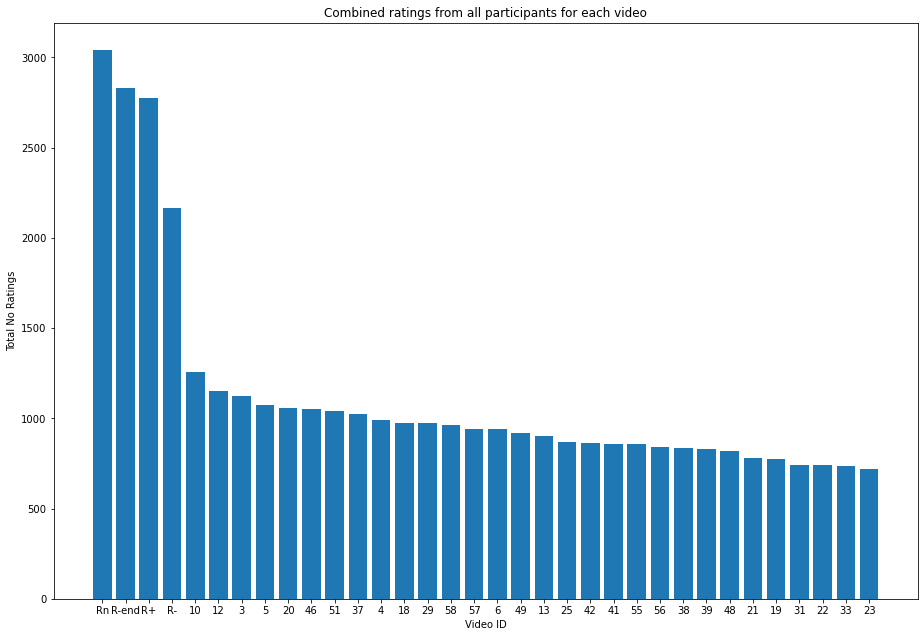

In [15]:
# Total Number of ratings per videoID
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.bar(df_number_of_ratings['VideoId'].astype(str),df_number_of_ratings['Total_No_Ratings'].values)
plt.xlabel('Video ID') 
plt.ylabel('Total No Ratings') 
plt.title("Combined ratings from all participants for each video")
save_path_plot = gen_path_plot("combined-total-ratings-per-video")
plt.savefig(save_path_plot,bbox_inches='tight')
plt.show()

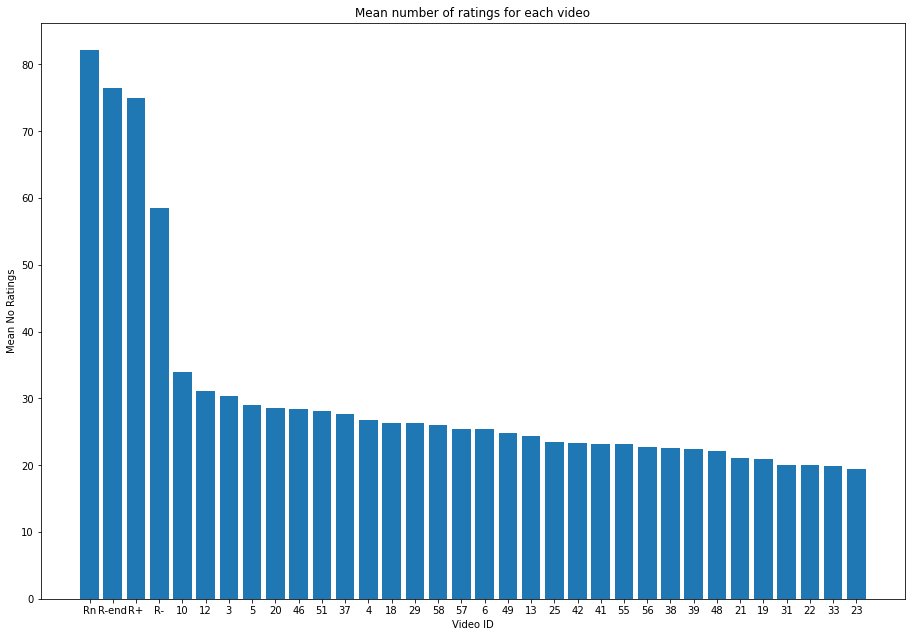

In [16]:
# Mean number of ratings per videoID
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.bar(df_number_of_ratings['VideoId'].astype(str),df_number_of_ratings['Mean_No_Ratings'].values)
plt.xlabel('Video ID') 
plt.ylabel('Mean No Ratings') 
plt.title("Mean number of ratings for each video")
save_path_plot = gen_path_plot("mean-number-of-ratings-per-video")
plt.savefig(save_path_plot,bbox_inches='tight')
plt.show()

In [17]:
# Average ratings per video
df_results_avg_affect_per_video = affect_ratings_matched_video_id.groupby(['p_index_id','VideoId']).mean(numeric_only=True).reset_index()
df_results_avg_affect_per_video

,p_index_id,VideoId,participant_id,Valence,Arousal,RawX,RawY
0,0,3,101.0,1.000000,8.300000,45.800000,180.400000
1,0,4,101.0,1.000000,8.181818,57.909091,177.727273
2,0,5,101.0,1.111111,6.888889,34.888889,155.666667
3,0,6,101.0,2.588235,6.882353,89.764706,155.588235
4,0,10,101.0,1.555556,7.888889,69.555556,171.888889
...,...,...,...,...,...,...,...
1236,36,58,382.0,8.687500,5.562500,204.562500,131.562500
1237,36,R+,382.0,7.688525,1.426230,182.049180,50.983607
1238,36,R-,382.0,8.200000,2.933333,193.066667,86.633333
1239,36,R-end,382.0,7.057143,1.600000,170.257143,67.800000


In [18]:
# Get the segment associated to a VideoId
affect_ratings_matched_video_id.head()

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
1,0,101,video_2,5,5,128,122,Positive,R+,End
2,0,101,video_2,6,5,149,127,Positive,R+,End
3,0,101,video_2,7,5,170,127,Positive,R+,End
4,0,101,video_2,8,5,193,126,Positive,R+,End
5,0,101,video_2,7,5,191,125,Positive,R+,End


In [19]:
matching_video_segment = affect_ratings_matched_video_id.groupby("VideoId").first()["Segment"]
matching_video_segment.head()

VideoId
3     Negative
4     Negative
5     Negative
6     Negative
10    Negative
Name: Segment, dtype: object

In [20]:
avg_aff = df_results_avg_affect_per_video.groupby(["VideoId"]).mean()[["Valence","Arousal"]].join(matching_video_segment).reset_index()
avg_aff["Segment"].iloc[ avg_aff["VideoId"].str.startswith("R").replace(np.nan, False) ] = "Rest"
avg_aff

,VideoId,Valence,Arousal,Segment
0,3,2.889383,6.842508,Negative
1,4,2.537035,6.701224,Negative
2,5,3.565138,5.452968,Negative
3,6,3.345589,5.811587,Negative
4,10,3.204039,6.723949,Negative
5,12,3.351549,6.236756,Negative
6,13,2.658598,6.651650,Negative
7,18,3.138331,5.557221,Negative
8,19,2.434184,5.623147,Negative
9,20,2.766511,6.810445,Negative


In [21]:
MEAN_RATINGS_FILENAME = gen_path_results("2_MeanRatings", extension=".csv")
average_ratings_value_and_number = pd.merge(avg_aff, df_number_of_ratings, on='VideoId', how='inner')
# Round the specified columns to three decimal places
average_ratings_value_and_number['Valence'] = average_ratings_value_and_number['Valence'].round(3)
average_ratings_value_and_number['Arousal'] = average_ratings_value_and_number['Arousal'].round(3)
average_ratings_value_and_number['Mean_No_Ratings'] = average_ratings_value_and_number['Mean_No_Ratings'].round(3)

average_ratings_value_and_number.to_csv(MEAN_RATINGS_FILENAME, index=False)
average_ratings_value_and_number

,VideoId,Valence,Arousal,Segment,Total_No_Ratings,Mean_No_Ratings
0,3,2.889,6.843,Negative,1125,30.405
1,4,2.537,6.701,Negative,993,26.838
2,5,3.565,5.453,Negative,1076,29.081
3,6,3.346,5.812,Negative,938,25.351
4,10,3.204,6.724,Negative,1256,33.946
5,12,3.352,6.237,Negative,1150,31.081
6,13,2.659,6.652,Negative,902,24.378
7,18,3.138,5.557,Negative,972,26.270
8,19,2.434,5.623,Negative,777,21.000
9,20,2.767,6.810,Negative,1057,28.568


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


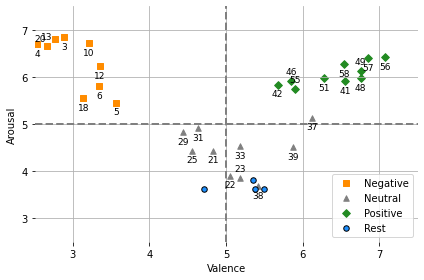

In [22]:
def generate_plot_affect_coordinates_ratings(df, ax):

    av_aff = df.copy()
    kwargs = {"Negative":{
                            "c":"darkorange", "marker":"s"
                            },
                    "Positive":{
                            "c":"forestgreen", "marker":"D"
                        },
                    "Neutral":{
                            "c":"grey", "marker":"^"
                        },
                    "Rest":{
                            "c":"dodgerblue", "marker":"o", "edgecolor":"k", "linewidths":1
                        }
                    }

    # colors = [kwargs[val]['c'] for val in avg_aff["Segment"]]
    # markers = [kwargs[val]['marker'] for val in avg_aff["Segment"]]
    # avg_aff.plot.scatter(ax=ax, x="Valence",y="Arousal",color=colors, markers=markers, legend=True)

    ax = plt.gca()
    # Plot
    offset_min = 2.5
    offset_max = 7.5
    ax.set(xlim=[offset_min,offset_max], ylim=[offset_min,offset_max])
    ax.set_xlabel("Valence")
    ax.set_ylabel("Arousal")
    # ax.set_title(f"Average Perceived Valence-Arousal ratings per video")

    ax.vlines([(offset_max+offset_min)/2], ymin=offset_min, ymax=offset_max, color="gray", linestyle='dashed', linewidth=2)
    ax.hlines([(offset_max+offset_min)/2], xmin=offset_min, xmax=offset_max, color="gray", linestyle='dashed', linewidth=2)
    ax.grid(True)
    ax.legend(loc="lower right")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for segment in av_aff["Segment"].unique():
        df_test = av_aff[ (av_aff["Segment"] == segment)]
        avg_V = df_test["Valence"] #((df_test.sum_RawX/df_test.N)-128)/256 # Normalized affect between 0-1
        avg_A = df_test["Arousal"] #((df_test.sum_RawY/df_test.N)-128)/256

        ax.scatter( avg_V, avg_A, label=segment, s=30, **kwargs[segment] ) #c=colors[segment], s=80, marker=markers[segment])

        for i, videoId in enumerate(df_test["VideoId"].values):
            avg_V = df_test["Valence"]
            avg_A = df_test["Arousal"]

            # Defines where to offset the annotations depending on how many neighbors are there
            offsetX = 0.2
            offsetY = 0.2

            offset_dict = {
                0: [0, -offsetY],
                1: [0, offsetY],
                2: [-offsetX, 0],
                3: [offsetX, 0]
            }
            # Define offset based on how many points are close to the value
            # np.random.seed(345)
            # offset_annotation = offset_dict[np.floor(np.random.randint(4))] #offset_dict[0] #offset_dict[np.floor(np.random.randint(4))]
            thresh = 0.2
            radius = np.sqrt(np.abs(avg_A.iloc[i] - avg_A.iloc[:i])**2 + (np.abs(avg_V.iloc[i] - avg_V.iloc[:i])**2))
            n_close_neighbors = (radius<thresh).sum()
            offset_annotation = offset_dict[n_close_neighbors]

            # Annotate
            if(segment != "Rest"):
                ax.annotate(videoId, (avg_V.iloc[i]+offset_annotation[0], 
                                    avg_A.iloc[i]+offset_annotation[1]), 
                                    fontsize=9, ha='center', va='center',
                                    color='k')  #kwargs[segment]["c"])
    
    ax.grid(True)
    ax.legend(loc="lower right")

    return ax

# Plotting how each video was rated among all self-reported datapoints across all 15 participants.
save_path_plot = gen_path_plot("affect-coordinates-ratings-per-video")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(6*NUM_COLS, 4*NUM_ROWS))

axes = generate_plot_affect_coordinates_ratings(avg_aff, axes)

plt.tight_layout()
plt.savefig(save_path_plot)


### Statistical analysis tests

Validate whether the average self-reported **valence** and **arousal** ratings differ between video categories aiming to induce `Negative`, `Neutral`, and `Positive` affect.

**Method:** Shapiro-Wilk normality tests followed by a Friedman and post-hoc Wilcoxon signed-rank.

*Test 1*: $H_0: \mu_- \geq \mu_N$ | $H_1: \mu_- < \mu_N$

If $p<0.01$, we reject the null hypothesis that the mean **reported valence/arousal** in the `Negative` videos $\mu_-$ is *greater or equal*  than in the `Neutral` videos $\mu_N$

*Test 2*: $H_0: \mu_+ \leq \mu_N$ | $H_1: \mu_+ > \mu_N$

If $p<0.01$, we reject the null hypothesis that the mean **reported valence/arousal** in the `Positive` videos $\mu_-$ is *lower or equal* than in the `Neutral` videos $\mu_N$


**Conclusions**

We validated whether the average self-reported ratings in valence and arousal differed between the three affect segments. Raw joystick input (0-255) was used instead of the translated 1-9 values. The continuous self-ratings were grouped by participant to calculate mean arousal and valence ratings per segment for each participant. We start by using Shapiro-Wilk tests to check for normality in valence ratings. Negative and neutral valence ratings were normally distributed ($W(39)=0.970, p=0.385$ and $W(39)=0.976, p=0.547$ respectively). Positive valence ratings were not ($W(39)=0.769, p<0.001$). Friedman test showed mean reported valence was significant different in all 3 segments ($X^2(2)=70.359, p<0.001$). Post-hoc Wilcoxon signed-rank tests for neutral vs negative, $Z=780, \; p<0.001$; positive vs neutral, $Z=740, \;  p<0.001$; positive vs negative, $Z=775, \;  p<0.001$).

Identical approach was applied to arousal ratings. Shapiro-Wilk tests showed that arousal ratings for videos in the positive category were not normally distributed $W(39)=0.976, p=0.570$, whereas Negative ($W(39)=0.943, p=0.049$) and Neutral ($W(39)=0.942, p=0.429$) arousal ratings are normally distributed. Friedman test showed arousal ratings were likewise different in all 3 segments ($X^2(2)=45.282, p<0.001$). Post-hoc Wilcoxon signed-rank showed Arousal ratings for both negative and positive categories were significantly higher from the neutral category ($Z=768, \;  p<0.001$; $Z=771, p<0.001$ respectively). As expected, due to highly arousing nature of both positive and negative videos, there was no significant difference in arousal for negative and positive categories ($Z=243, \; p=0.981$).

In [23]:
affect_ratings_matched_video_id

,p_index_id,participant_id,Session,Valence,Arousal,RawX,RawY,Segment,VideoId,Trigger
1,0,101,video_2,5,5,128,122,Positive,R+,End
2,0,101,video_2,6,5,149,127,Positive,R+,End
3,0,101,video_2,7,5,170,127,Positive,R+,End
4,0,101,video_2,8,5,193,126,Positive,R+,End
5,0,101,video_2,7,5,191,125,Positive,R+,End
...,...,...,...,...,...,...,...,...,...,...
38822,36,382,video_5,8,1,179,61,video_5,R-end,End
38823,36,382,video_5,7,1,178,61,video_5,R-end,End
38824,36,382,video_5,8,1,179,61,video_5,R-end,End
38825,36,382,video_5,7,1,178,61,video_5,R-end,End


In [24]:
# Group self ratings by partipant and segment
X = affect_ratings_matched_video_id.copy()
X["VideoId"] = pd.Categorical(X["VideoId"], categories=X["VideoId"].unique(), ordered=False)
df_participant_segment_ratings = X.groupby(["p_index_id","Segment"]).mean(numeric_only=True).reset_index().set_index(["p_index_id"])
df_participant_segment_ratings

,Segment,participant_id,Valence,Arousal,RawX,RawY
p_index_id,,,,,,
0,Negative,101.0,2.470588,6.191176,82.139706,139.117647
0,Neutral,101.0,5.636364,4.895105,150.468531,119.776224
0,Positive,101.0,6.461538,5.851648,164.214286,137.983516
0,video_5,101.0,3.733333,1.000000,111.266667,20.266667
1,Negative,216.0,3.167641,6.231969,101.015595,144.970760
...,...,...,...,...,...,...
35,video_5,381.0,4.955056,3.752809,132.337079,93.123596
36,Negative,382.0,3.337838,5.875000,103.591216,137.010135
36,Neutral,382.0,5.958333,4.625000,152.303571,116.315476


In [25]:
# Generate DF with all participants and all videoIds (even if they have no ratings)
# result should be an array of 39 participants * 34 (30 videos, 10 per segment plus 4 relaxing videos) videos per segment = 1326
df_avg_per_participant_and_video = X.groupby(["p_index_id","VideoId"]).mean(numeric_only=True).reset_index().set_index(["VideoId"])
df_avg_per_participant_and_video

C:\Users\masqu\AppData\Local\Temp\ipykernel_11052\2227314311.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg_per_participant_and_video = X.groupby(["p_index_id","VideoId"]).mean(numeric_only=True).reset_index().set_index(["VideoId"])


,p_index_id,participant_id,Valence,Arousal,RawX,RawY
VideoId,,,,,,
R+,0,101.0,6.632653,3.040816,165.285714,88.571429
51,0,101.0,4.666667,6.047619,133.142857,139.047619
49,0,101.0,7.400000,7.600000,174.550000,166.800000
46,0,101.0,6.800000,6.900000,171.400000,154.200000
41,0,101.0,7.666667,5.000000,189.333333,123.444444
...,...,...,...,...,...,...
22,36,382.0,5.777778,3.111111,152.333333,88.777778
39,36,382.0,5.888889,4.222222,152.333333,106.000000
23,36,382.0,4.857143,5.142857,137.714286,127.428571


**Valence**

We analyze `RawX` instead of `Valence` because it contains the raw reported values from the joystick and has not been quantisized in the `9-level` variable of valence.

In [26]:
# Extract valence ratings for each segment (negative, positive & neutral)
negative_valence = df_participant_segment_ratings['RawX'][df_participant_segment_ratings['Segment']=='Negative']
positive_valence = df_participant_segment_ratings['RawX'][df_participant_segment_ratings['Segment']=='Positive']
neutral_valence = df_participant_segment_ratings['RawX'][df_participant_segment_ratings['Segment']=='Neutral']
print(f"N = {negative_valence.size}")

N = 37


In [27]:
print(f"Negative: \t{negative_valence.mean()} +/- ({negative_valence.std()})")
print(f"Neutral: \t{neutral_valence.mean()} +/- ({neutral_valence.std()})")
print(f"Positive: \t{positive_valence.mean()} +/- ({positive_valence.std()})")

Negative: 	108.06311534834518 +/- (13.560995026505992)
Neutral: 	139.25683547653907 +/- (9.850596173616307)
Positive: 	156.95509694096734 +/- (17.78063947837294)


In [28]:
# Shapiro-Wilk normality tests for valence self ratings
print('Negative Valence: ' + str(stats.shapiro(negative_valence)))
print('Positive Valence: ' + str(stats.shapiro(positive_valence)))
print('Neutral Valence: ' + str(stats.shapiro(neutral_valence)))

Negative Valence: ShapiroResult(statistic=0.9701035618782043, pvalue=0.41115760803222656)
Positive Valence: ShapiroResult(statistic=0.7728224396705627, pvalue=3.870069122058339e-06)
Neutral Valence: ShapiroResult(statistic=0.9727119207382202, pvalue=0.48669350147247314)


In [29]:
# Non parametric Friedman test for valence self ratings
stats.friedmanchisquare(negative_valence, positive_valence, neutral_valence)

FriedmanchisquareResult(statistic=66.37837837837839, pvalue=3.855833536113861e-15)

In [30]:
# Post-hoc Wilcoxon tests for valence self ratings
# NEUTRAL > NEGATIVE
#Wilcoxon signed-rank test (paired)
test1 = stats.wilcoxon(neutral_valence, negative_valence, alternative='greater')
print(test1)

WilcoxonResult(statistic=703.0, pvalue=7.275957614183426e-12)


In [31]:
# POSITIVE > NEUTRAL
test2 = stats.wilcoxon(positive_valence, neutral_valence, alternative="greater")
print(test2)

WilcoxonResult(statistic=665.0, pvalue=4.8028596211224794e-08)


In [32]:
# POSITIVE > NEGATIVE
test3 = stats.wilcoxon(positive_valence, negative_valence, alternative="greater")
print(test3)

WilcoxonResult(statistic=698.0, pvalue=7.275957614183426e-11)


In [33]:
save_path_text = gen_path_results("2_Affect_Valence_Paired-T-Tests", extension=".txt")
f = open(save_path_text, "w")
f.write("Test 1: (H1) Negative < than Neutral:\t" + str(test1) + "\n")
f.write("Test 2: (H1) Positive > than Neutral:\t" + str(test2) + "\n")
f.write("Test 3: (H1) Positive > than Negative:\t" + str(test3) + "\n")
f.close()

**Arousal**

Analyzing average value from `RawY` from the joystick

In [34]:
# Extract valence ratings for each segment (negative, positive & neutral)
negative_arousal = df_participant_segment_ratings['RawY'][df_participant_segment_ratings['Segment']=='Negative']
positive_arousal = df_participant_segment_ratings['RawY'][df_participant_segment_ratings['Segment']=='Positive']
neutral_arousal = df_participant_segment_ratings['RawY'][df_participant_segment_ratings['Segment']=='Neutral']
print(f"N = {negative_arousal.size}")

N = 37


In [35]:
print(f"Negative: \t{negative_arousal.mean()} +/- ({negative_arousal.std()})")
print(f"Neutral: \t{positive_arousal.mean()} +/- ({positive_arousal.std()})")
print(f"Positive: \t{neutral_arousal.mean()} +/- ({neutral_arousal.std()})")

Negative: 	138.06722131031214 +/- (13.086383201036952)
Neutral: 	131.91715149795544 +/- (14.891850295488986)
Positive: 	112.15615538041834 +/- (16.01116738309113)


In [36]:
# Shapiro-Wilk normality tests for valence self ratings
print('Negative Arousal: ' + str(stats.shapiro(negative_arousal)))
print('Positive Arousal: ' + str(stats.shapiro(positive_arousal)))
print('Neutral Arousal: ' + str(stats.shapiro(neutral_arousal)))

Negative Arousal: ShapiroResult(statistic=0.9397934079170227, pvalue=0.04543507099151611)
Positive Arousal: ShapiroResult(statistic=0.974888801574707, pvalue=0.5559741258621216)
Neutral Arousal: ShapiroResult(statistic=0.940395176410675, pvalue=0.04748091846704483)


In [37]:
# Non parametric Friedman test for arousal self ratings
stats.friedmanchisquare(negative_arousal, positive_arousal, neutral_arousal)

FriedmanchisquareResult(statistic=42.378378378378386, pvalue=6.275553829166123e-10)

In [38]:
# Statistical test: paired t-test
test1 = stats.wilcoxon(negative_arousal, neutral_arousal, alternative="greater")
print(test1)
test2 = stats.wilcoxon(positive_arousal, neutral_arousal, alternative="greater")
print(test2)
test3 = stats.wilcoxon(positive_arousal, negative_arousal, alternative="greater")
print(test3)

save_path_text = gen_path_results("_Affect_Arousal_Paired-T-Tests", extension=".txt")
f = open(save_path_text, "w")
f.write("Test 1: (H1) Negative > than Neutral:\t" + str(test1) + "\n")
f.write("Test 2: (H1) Positive > than Neutral:\t" + str(test2) + "\n")
f.write("Test 3: (H1) Positive > than Negative:\t" + str(test3) + "\n")
f.close()

WilcoxonResult(statistic=693.0, pvalue=3.128661774098873e-10)
WilcoxonResult(statistic=694.0, pvalue=2.4010660126805305e-10)
WilcoxonResult(statistic=210.0, pvalue=0.9844936368026538)


### Boxplots average ratings per video

In [39]:
df_avg_affect_with_segment = df_avg_per_participant_and_video.join(matching_video_segment).reset_index()
# Group relaxing videos together under the same sequence for plotting
df_avg_affect_with_segment['VideoId'] = df_avg_affect_with_segment['VideoId'].astype(str)
df_avg_affect_with_segment['Segment'].mask(df_avg_affect_with_segment['VideoId'].str.contains('R'), 'Relax', inplace=True)

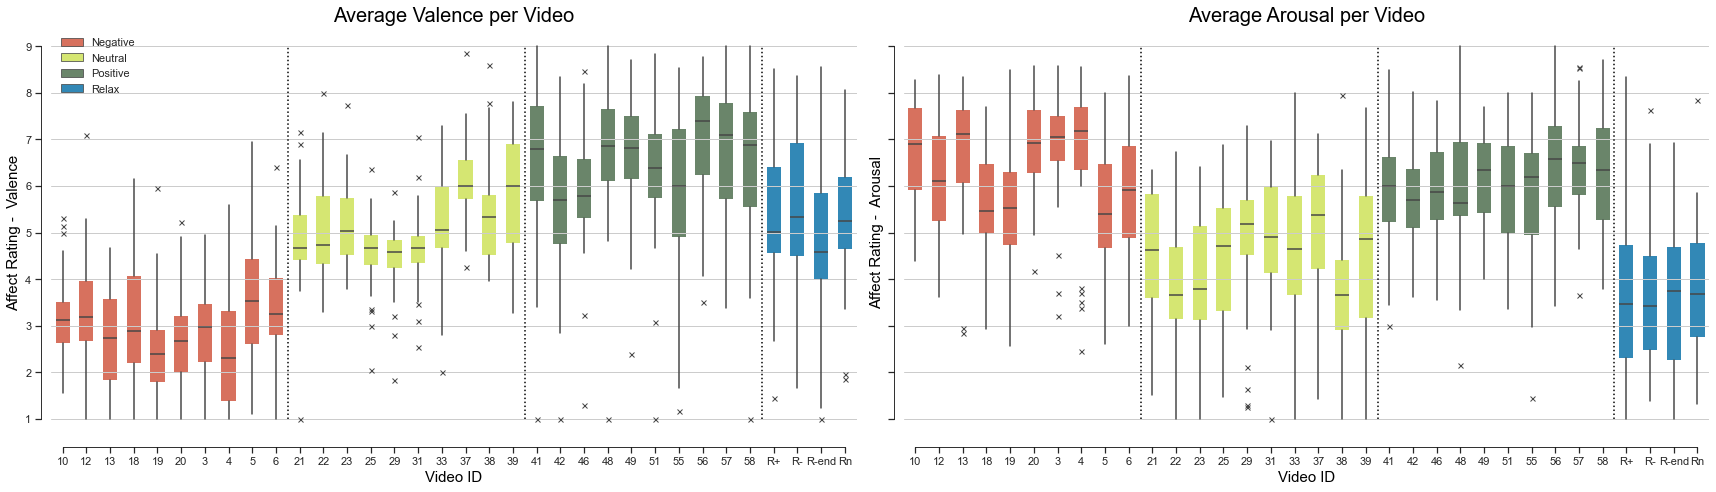

In [40]:
def generate_plot_affect_boxplot_ratings(df_results, axis_to_plot, colname, title):
    ax = axis_to_plot
    # Sort groups
    df_avg_affect_2 = df_results.copy()
    df_avg_affect_2.sort_values(by=["VideoId"], inplace=True, key= lambda col: col.map(lambda item: ([str,int].index(type(item)), item) ) ) # Make letters come before numbers
    df_avg_affect_2.sort_values(by=["Segment"], ascending=True, kind="mergesort", inplace=True) # Mergesort keeps respecting the previous sorting decision.

    # Rename columns
    df_avg_affect_2.rename( columns = {
                "Segment":"Exp. Segment",
                "VideoId": "Video ID",
                "Valence":"Avg. Valence",
                "Arousal":"Avg. Arousal"
                }, inplace = True )
    
    sns.set_theme(style="ticks")
    
    PALETTE_COLORS = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Relax.value]

    # Vertical lines separating the experimental sessions
    ax.vlines([9.5, 19.5, 29.5], ymin=1, ymax=9, color="black", linestyle='dotted', linewidth=1.5)
    ax.grid(axis="y")

    # Filter the data that has to do with this column label
    sns.boxplot(data=df_avg_affect_2, ax=ax,
                x="Video ID", y=colname, hue="Exp. Segment", #orient="h",
                width=0.6, palette=PALETTE_COLORS, dodge =False,
                # notch=True, 
                showcaps=False,
                flierprops={"marker": "x"},
                boxprops={"edgecolor": "none"},
                # medianprops={"color": "coral"}
                )
    
    sns.despine(offset=10, trim=True)
    sns.move_legend(ax, loc="best", title=None, frameon=False)

    ax.set_ylabel(f"Affect Rating - {colname.split('.')[-1]}", fontsize = 15)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Video ID", fontsize=15)
    if('Arousal' in title):
        ax.get_legend().remove()
    return ax

### Generate path to save and figure
save_path_plot = gen_path_plot(f"affect-boxplot-ratings-per-video")

NUM_ROWS = 1
NUM_COLS = 2
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(12*NUM_COLS, 7*NUM_ROWS))

COL_TITLES = ["Avg. Valence", "Avg. Arousal"]
PLOT_TITLES = ["Average Valence per Video", "Average Arousal per Video"]
for i in range(len(COL_TITLES)):
    axes[i] = generate_plot_affect_boxplot_ratings(df_avg_affect_with_segment, axes[i], COL_TITLES[i], PLOT_TITLES[i])

plt.tight_layout()
plt.savefig(save_path_plot)

---
## Analyzing postprocessed dataset and features

The following blocks use compiled dataset created during the notebook `1_...ipynb`. It contains a subset from the AVDOS-VR dataset with physiological data resampled at 50Hz, subset of relevant columns, and synchronized with affect events and experimental affective segments.

In [5]:
# Load the dataset
DATASET_POSTPROCESSED_FILENAME = ROOT + "/temp/1_preprocess/Dataset_AVDOSVR_postprocessed.csv"
DATASET_POSTPROCESSED_FILENAME

'F:\\AVDOS-VR//temp/1_preprocess/Dataset_AVDOSVR_postprocessed.csv'

In [6]:
# Load the file in memory (~700MB)
dataset = pd.read_csv(DATASET_POSTPROCESSED_FILENAME)

In [7]:
dataset.columns

Index(['Participant', 'Stage', 'Time', 'OriginalParticipantID',
       'Emg/Amplitude[RightZygomaticus]', 'Emg/Contact[RightFrontalis]',
       'Emg/Contact[CenterCorrugator]', 'Gyroscope/Raw.y',
       'Accelerometer/Raw.z', 'Emg/Amplitude[RightOrbicularis]',
       'Emg/Contact[LeftZygomaticus]', 'Emg/Amplitude[LeftFrontalis]',
       'Ppg/Raw.ppg', 'Accelerometer/Raw.y', 'Emg/Amplitude[RightFrontalis]',
       'Magnetometer/Raw.z', 'Emg/Contact[RightOrbicularis]',
       'Magnetometer/Raw.y', 'Gyroscope/Raw.x', 'Gyroscope/Raw.z',
       'Faceplate/FitState', 'HeartRate/Average', 'Faceplate/FaceState',
       'Ppg/Raw.proximity', 'Magnetometer/Raw.x', 'Emg/Contact[LeftFrontalis]',
       'Accelerometer/Raw.x', 'Emg/Amplitude[CenterCorrugator]',
       'Emg/Contact[RightZygomaticus]', 'Emg/Amplitude[LeftOrbicularis]',
       'Emg/Contact[LeftOrbicularis]', 'Emg/Amplitude[LeftZygomaticus]',
       'VideoId', 'Valence', 'Arousal', 'RawX', 'RawY'],
      dtype='object')

### General variables

The following variables store important info about the dataset. How many participants? Which video segments are included? Which videoIds are contained in each affective segment?

In [44]:
participants_ids = dataset["Participant"].unique()
participants_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int64)

In [45]:
experiment_segment_names = dataset["Stage"].unique()
experiment_segment_names

array(['Resting_Positive', 'Positive', 'Resting_Negative', 'Negative',
       'Resting_Neutral', 'Neutral'], dtype=object)

In [46]:
video_ids = dataset["VideoId"].unique()
print(np.sort(video_ids))
# -1 refers to the resting stages, no video is presented.

[-1.  3.  4.  5.  6. 10. 12. 13. 18. 19. 20. 21. 22. 23. 25. 29. 31. 33.
 37. 38. 39. 41. 42. 46. 48. 49. 51. 55. 56. 57. 58.]


In [47]:
# All rows inside the `video` stage should contain a VideoId different than -1,
# As -1 denotes a resting video. The following code verifies that there are no invalid rows.
Q = (( dataset["VideoId"]==-1) & ~(dataset["Stage"].str.startswith("Resting_")))
dataset[Q]

# NOTE: The result should be and empty DF.

,Participant,Stage,Time,OriginalParticipantID,Emg/Amplitude[RightZygomaticus],Emg/Contact[RightFrontalis],Emg/Contact[CenterCorrugator],Gyroscope/Raw.y,Accelerometer/Raw.z,Emg/Amplitude[RightOrbicularis],Emg/Contact[LeftZygomaticus],Emg/Amplitude[LeftFrontalis],Ppg/Raw.ppg,Accelerometer/Raw.y,Emg/Amplitude[RightFrontalis],Magnetometer/Raw.z,Emg/Contact[RightOrbicularis],Magnetometer/Raw.y,Gyroscope/Raw.x,Gyroscope/Raw.z,Faceplate/FitState,HeartRate/Average,Faceplate/FaceState,Ppg/Raw.proximity,Magnetometer/Raw.x,Emg/Contact[LeftFrontalis],Accelerometer/Raw.x,Emg/Amplitude[CenterCorrugator],Emg/Contact[RightZygomaticus],Emg/Amplitude[LeftOrbicularis],Emg/Contact[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],VideoId,Valence,Arousal,RawX,RawY


In [48]:
# Generate a dictionary with the stage and their corresponding list of `VideoId`
# Confirm the unique Video IDs in each experimental segment
video_ids_per_segment = {}
for segment in experiment_segment_names:
    video_ids_per_segment[segment] = np.array([])
    # Keep unique video ids
    Q = ( dataset["Stage"] == segment )
    video_ids_per_segment[segment] = dataset[Q]["VideoId"].unique()
video_ids_per_segment

{'Resting_Positive': array([-1.]),
 'Positive': array([51., 49., 46., 41., 48., 57., 56., 58., 42., 55.]),
 'Resting_Negative': array([-1.]),
 'Negative': array([18., 10.,  5., 13., 12., 19.,  3.,  4., 20.,  6.]),
 'Resting_Neutral': array([-1.]),
 'Neutral': array([25., 38., 29., 37., 31., 33., 22., 39., 23., 21.])}

In [49]:
# The index is in the order ["Participant", "AffectSegment", "Time"]
# It allows multidimensional manipulation in a 2D pandas structure
data = dataset.set_index(["Participant","Stage","Time"])
data.sort_index(inplace=True)
data.head()

OriginalParticipantID  ...  RawY
Participant Stage    Time                         ...      
0           Negative 0.00                    101  ...   NaN
                     0.02                    101  ...   NaN
                     0.04                    101  ...   NaN
                     0.06                    101  ...   NaN
                     0.08                    101  ...   NaN

[5 rows x 34 columns]

### EDA - Accessing single participant's data
Exploratory Data Analysis (EDA) to visualize a particular experimental segment from a specific participant

In [50]:
PARTICIPANT_IDX = 1
EXPERIMENTAL_SEGMENT = "Positive"
# Access the dictionary of videos existing in the segment, choose the first VideoID
VIDEO_ID = video_ids_per_segment[EXPERIMENTAL_SEGMENT][0] 

##
# Select a whole experimental segment
single_segment_ts = data.loc[(PARTICIPANT_IDX,EXPERIMENTAL_SEGMENT)]
# Select a specific video inside the experimental segment
single_video_ts = single_segment_ts[ single_segment_ts["VideoId"] == VIDEO_ID]

array([<Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>], dtype=object)

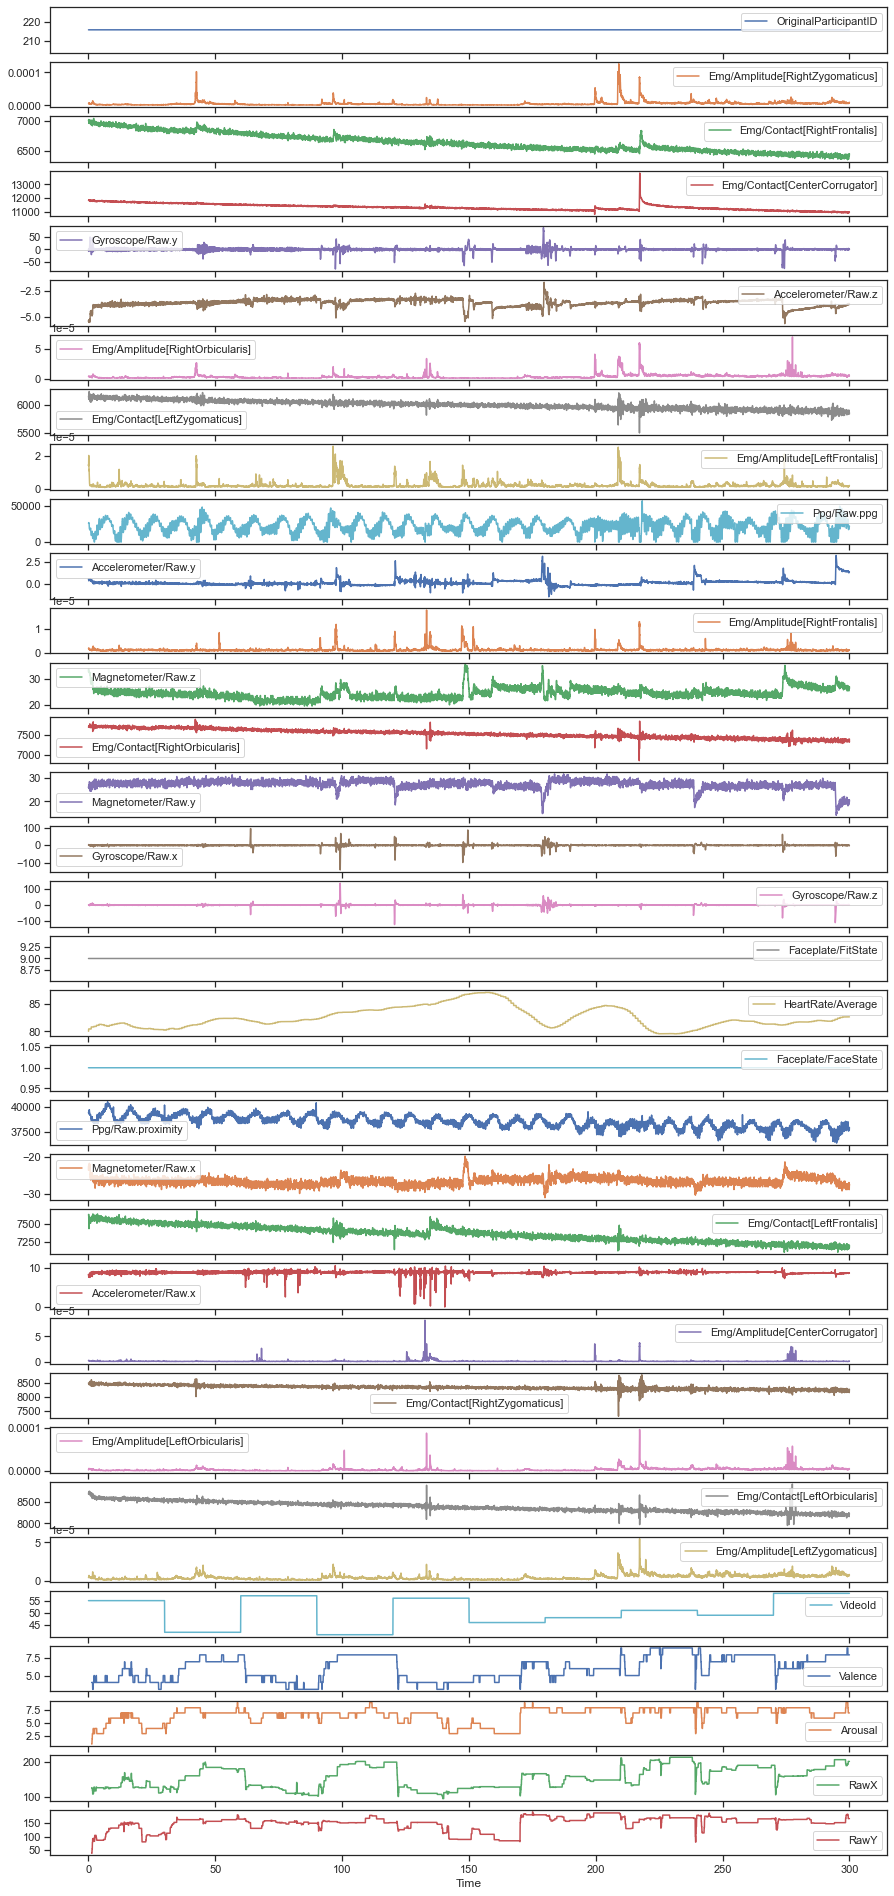

In [51]:
single_segment_ts.plot.line(subplots=True, figsize=(15,1*single_segment_ts.shape[1]), sharex=True)

array([<Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>], dtype=object)

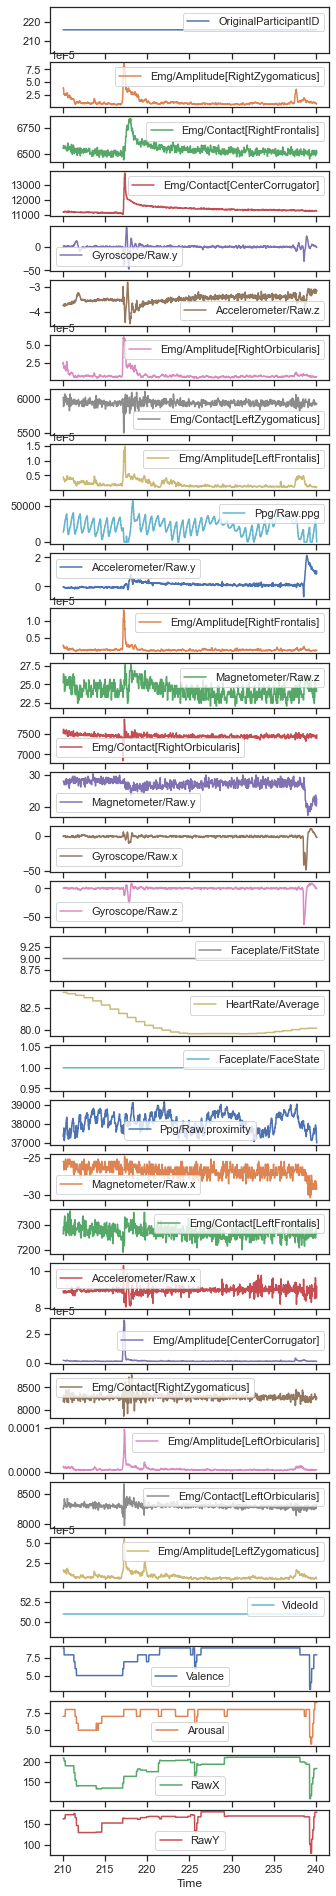

In [52]:
single_video_ts.plot.line(subplots=True, figsize=(5,1*single_video_ts.shape[1]), sharex=True)

# Time analysis of self-ratings

In [13]:
# Plotting Valence for all videos as separate lines using Seaborn

def plot_mean_ratings_over_time(affect_measure, category):

    plt.figure(figsize=(12, 5))
    for video_id in mean_valence_arousal.index.levels[0]:
        affect_data = mean_valence_arousal.xs(video_id)[affect_measure]
        line = sns.lineplot(data=affect_data, label=f'Video {video_id}')
    
    plt.title('Mean ' + affect_measure + ' for ' + category + ' Videos', fontweight='bold')
    plt.xlabel('Time (seconds)', fontweight='bold')
    plt.ylabel(affect_measure, fontweight='bold')
    plt.legend()
    
    # Setting x-axis ticks for 0 to 30 seconds
    plt.xticks(ticks=range(0, 1501, 50), labels=range(0, 31, 1))
    
    # Increase legend line thickness
    lines = line.get_lines()
    for l in lines:
        l.set_linewidth(2.5)  # Adjust the thickness here
    
    # Adjusting legend line length without changing overall legend size
    leg = plt.legend()
    for line in leg.get_lines():
        #line.set_linestyle('-')  # Adjust the line style here
        line.set_linewidth(5)  # Adjust the line width here

    # Set y-axis limits
    plt.ylim(1, 9)
    
    # Removing gridlines
    #sns.set_style("white")
    sns.set_style("whitegrid")
    save_path_plot = gen_path_plot(f"time_ratings" + "_" + category + "_" + affect_measure, '.png')
    plt.tight_layout()
    plt.savefig(save_path_plot)
    
    plt.show()

In [21]:
import pandas as pd

categories = ['Positive', 'Neutral', 'Negative']

#category = 'Positive'

for category in categories:

    positive_videos = dataset[dataset['Stage'].str.contains(category)]
    new_df = pd.DataFrame(columns=['Participant', 'VideoId', 'Valence', 'Arousal'])
    
    for video_id in positive_videos['VideoId'].unique():
        for participant_id in positive_videos[positive_videos['VideoId'] == video_id]['Participant'].unique():
            participant_data = positive_videos[(positive_videos['VideoId'] == video_id) & (positive_videos['Participant'] == participant_id)].iloc[:1500]
            if not participant_data.empty:
                valence_data = participant_data['Valence'].values
                arousal_data = participant_data['Arousal'].values
                data_to_add = {
                    'Participant': participant_id,
                    'VideoId': video_id,
                    'Valence': valence_data,
                    'Arousal': arousal_data
                }
                new_df = pd.concat([new_df, pd.DataFrame(data_to_add)])

    mean_valence_arousal = new_df.groupby(['VideoId', new_df.index])[['Valence', 'Arousal']].mean(numeric_only=True)
    mean_valence_arousal.index = mean_valence_arousal.index.set_levels(mean_valence_arousal.index.levels[0].astype(int), level=0)
    # Change VideoId values to 'R' if they are equal to -1
    mean_valence_arousal.index = mean_valence_arousal.index.set_levels(mean_valence_arousal.index.levels[0].where(mean_valence_arousal.index.levels[0] != -1, 'R'), level=0)
    #plt.plot(mean_valence_arousal.xs(41.0)['Valence'])
    plot_mean_ratings_over_time('Valence', category)
    plot_mean_ratings_over_time('Arousal', category)

---
## Analysis 2: Feature-based classification

Feature-based classification assuming that the features captured with overlapping windows act as independent samples, unlike in time-series classification.

Feature extraction steps:
1. Traverse the time-series data per participant and per experimental segment: (~300secs per video segment).
2. Consider the following stages as target classes: `[Positive, Neutral, Negative]`.
3. Take the corresponding resting stages ( `[Resting_Negative, Resting_Neutral, Resting_VideoPositive]`) to fit a standardizer ($\mu=0,\sigma=1$)
4. Apply a sliding window of specific width and overlap to extract **statistical features** (11 features per dimension) from: `[HEART, MOTOR, FACE]`.
5. In addition, calculate **time-domain HRV features** from the non-standardized version of the PPG signal (5 features from PPG).

In [54]:
ORIG_SAMP_FREQUENCY_HZ = 50

WINDOW_WIDTH_SECS = 30
WINDOW_OVERLAP_SECS = 10

In [55]:
# Copy the original dataset again
data = dataset.copy().set_index(["Participant","Stage","Time"])
data.sort_index(inplace=True)
data.head()

OriginalParticipantID  \
Participant Stage    Time                          
0           Negative 0.00                    101   
                     0.02                    101   
                     0.04                    101   
                     0.06                    101   
                     0.08                    101   

                           Emg/Amplitude[LeftOrbicularis]  \
Participant Stage    Time                                   
0           Negative 0.00                        0.000002   
                     0.02                        0.000002   
                     0.04                        0.000002   
                     0.06                        0.000002   
                     0.08                        0.000002   

                           Accelerometer/Raw.z  Gyroscope/Raw.y  \
Participant Stage    Time                                         
0           Negative 0.00                -4.57           0.0000   
                     0.02                -4.56           1.1250   
                     0.04                -4.53           1.5625   
                     0.06                -4.53           1.5625   
                     0.08                -4.53           1.1250   

                           Faceplate/FitState  Accelerometer/Raw.y  \
Participant Stage    Time                                            
0           Negative 0.00                   9                 0.49   
                     0.02                   9                 0.49   
                     0.04                   9                 0.48   
                     0.06                   9                 0.49   
                     0.08                   9                 0.45   

                           Gyroscope/Raw.x  Emg/Amplitude[RightOrbicularis]  \
Participant Stage    Time                                                     
0           Negative 0.00          -0.1250                         0.000003   
                     0.02           0.3750                         0.000003   
                     0.04          -0.5000                         0.000004   
                     0.06           0.5625                         0.000004   
                     0.08           0.5625                         0.000003   

                           Emg/Contact[RightZygomaticus]  \
Participant Stage    Time                                  
0           Negative 0.00                         3624.0   
                     0.02                         3574.0   
                     0.04                         3574.0   
                     0.06                         3560.0   
                     0.08                         3560.0   

                           Emg/Amplitude[LeftZygomaticus]  ...  \
Participant Stage    Time                                  ...   
0           Negative 0.00                        0.000002  ...   
                     0.02                        0.000002  ...   
                     0.04                        0.000002  ...   
                     0.06                        0.000002  ...   
                     0.08                        0.000002  ...   

                           Emg/Contact[CenterCorrugator]  Magnetometer/Raw.y  \
Participant Stage    Time                                                      
0           Negative 0.00                         6338.0             -24.375   
                     0.02                         6308.0             -24.375   
                     0.04                         6308.0             -24.000   
                     0.06                         6300.0             -24.000   
                     0.08                         6300.0             -22.875   

                           Emg/Amplitude[CenterCorrugator]  \
Participant Stage    Time                                    
0           Negative 0.00                         0.000002   
                     0.02                         0.000002   
                     0.04 

In [56]:
data.columns

Index(['OriginalParticipantID', 'Emg/Amplitude[RightZygomaticus]',
       'Emg/Contact[RightFrontalis]', 'Emg/Contact[CenterCorrugator]',
       'Gyroscope/Raw.y', 'Accelerometer/Raw.z',
       'Emg/Amplitude[RightOrbicularis]', 'Emg/Contact[LeftZygomaticus]',
       'Emg/Amplitude[LeftFrontalis]', 'Ppg/Raw.ppg', 'Accelerometer/Raw.y',
       'Emg/Amplitude[RightFrontalis]', 'Magnetometer/Raw.z',
       'Emg/Contact[RightOrbicularis]', 'Magnetometer/Raw.y',
       'Gyroscope/Raw.x', 'Gyroscope/Raw.z', 'Faceplate/FitState',
       'HeartRate/Average', 'Faceplate/FaceState', 'Ppg/Raw.proximity',
       'Magnetometer/Raw.x', 'Emg/Contact[LeftFrontalis]',
       'Accelerometer/Raw.x', 'Emg/Amplitude[CenterCorrugator]',
       'Emg/Contact[RightZygomaticus]', 'Emg/Amplitude[LeftOrbicularis]',
       'Emg/Contact[LeftOrbicularis]', 'Emg/Amplitude[LeftZygomaticus]',
       'VideoId', 'Valence', 'Arousal', 'RawX', 'RawY'],
      dtype='object')

In [57]:
# Identify groups of features
basic_colnames = avdosvr.preprocessing.COLNAMES_AFFECT
hrv_colnames = avdosvr.preprocessing.COLNAMES_HR + avdosvr.preprocessing.COLNAMES_PPG
imu_colnames = avdosvr.preprocessing.COLNAMES_ACCELEROMETER + avdosvr.preprocessing.COLNAMES_MAGNETOMETER + avdosvr.preprocessing.COLNAMES_GYROSCOPE
emg_colnames = avdosvr.preprocessing.COLNAMES_EMG_AMPLITUDE
emg_contact_colnames = avdosvr.preprocessing.COLNAMES_EMG_CONTACT

In [58]:
# Identify colnames that have relevant time-series data (exclude videoId, affect, etc.)
TS_DATA_COLNAMES = basic_colnames + hrv_colnames + imu_colnames + emg_colnames + emg_contact_colnames
TS_DATA_COLNAMES

['Valence',
 'Arousal',
 'RawX',
 'RawY',
 'HeartRate/Average',
 'Ppg/Raw.ppg',
 'Ppg/Raw.proximity',
 'Accelerometer/Raw.x',
 'Accelerometer/Raw.y',
 'Accelerometer/Raw.z',
 'Magnetometer/Raw.x',
 'Magnetometer/Raw.y',
 'Magnetometer/Raw.z',
 'Gyroscope/Raw.x',
 'Gyroscope/Raw.y',
 'Gyroscope/Raw.z',
 'Emg/Amplitude[RightFrontalis]',
 'Emg/Amplitude[RightZygomaticus]',
 'Emg/Amplitude[RightOrbicularis]',
 'Emg/Amplitude[CenterCorrugator]',
 'Emg/Amplitude[LeftOrbicularis]',
 'Emg/Amplitude[LeftZygomaticus]',
 'Emg/Amplitude[LeftFrontalis]',
 'Emg/Contact[RightFrontalis]',
 'Emg/Contact[RightZygomaticus]',
 'Emg/Contact[RightOrbicularis]',
 'Emg/Contact[CenterCorrugator]',
 'Emg/Contact[LeftOrbicularis]',
 'Emg/Contact[LeftZygomaticus]',
 'Emg/Contact[LeftFrontalis]']

### Propagate missing values from the beginning of the continuous annotations

In [59]:
data[basic_colnames].isna().sum()

Valence    27902
Arousal    27902
RawX       27902
RawY       27902
dtype: int64

In [60]:
data[basic_colnames] = data[basic_colnames].fillna(method='bfill')

In [61]:
data[basic_colnames].isna().sum()

Valence    0
Arousal    0
RawX       0
RawY       0
dtype: int64

In [62]:
def filter_outliers_from_df(df, num_std = 2):
    """
    Takes a multidimensional dataFrame and filter the values
    that are `num_std` standard deviations away from the mean value
    of the column.

    First, it transforms the value in np.nan. Then, it imputes the
    value with backward filling, and then with forward filling, in case
    the missing values are generated on the extremes of the time-series.

    Returns the filtered dataset
    """
    mask = (( df > (df.mean() + num_std*df.std())) | ( df < (df.mean() - num_std*df.std())) )
    df[ mask ] = np.nan
    df_filtered = df.fillna(method="backfill", axis=0)
    df_filtered = df_filtered.fillna(method="ffill", axis=0)
    print(f"\tTotal NAs --> Generated={df.isna().sum().sum()} - After imputation={df_filtered.isna().sum().sum()}")
    return df_filtered

*Testing feature extraction in one instance*...

In [63]:
# INSTANCE
PARTICIPANT_IDX = 20
EXP_SEGMENT = str(avdosvr.preprocessing.AffectSegments.VideosNeutral)
VIDEO_ID = video_ids_per_segment[EXP_SEGMENT][0]

print(f"participant={PARTICIPANT_IDX}, segment={EXP_SEGMENT}, video_id={VIDEO_ID}")

participant=20, segment=Neutral, video_id=25.0


**Preparing resting stage as baseline for the scaler**

In [64]:
# Read from dataset data from a VIDEO segment and its corresponding RESTING stage
single_segment_ts = data.loc[(PARTICIPANT_IDX,EXP_SEGMENT)]

# Filter data with FitState >= average (8)
single_segment_ts = single_segment_ts[ single_segment_ts["Faceplate/FitState"] > 7]
single_segment_ts = single_segment_ts[TS_DATA_COLNAMES] # Choose columns with relevant data

# This resting stages will be used to normalize the values.
single_segment_resting = data.loc[(PARTICIPANT_IDX,"Resting_"+EXP_SEGMENT)]
# Filter data with FitState >= average (8)
single_segment_resting = single_segment_resting[ single_segment_resting["Faceplate/FitState"] > 7]

print(f"Video df shape: {single_segment_ts.shape}")
print(f"Resting df shape: {single_segment_resting.shape}")

Video df shape: (14900, 30)
Resting df shape: (5982, 34)


All data from each participant used for standarisation:

In [65]:
# Load all the data from a participant across all experiments
single_participants_data = data.loc[(PARTICIPANT_IDX)]
single_participants_data

OriginalParticipantID  \
Stage            Time                            
Negative         0.00                      330   
                 0.02                      330   
                 0.04                      330   
                 0.06                      330   
                 0.08                      330   
...                                        ...   
Resting_Positive 119.92                    330   
                 119.94                    330   
                 119.96                    330   
                 119.98                    330   
                 120.00                    330   

                         Emg/Amplitude[LeftOrbicularis]  Accelerometer/Raw.z  \
Stage            Time                                                          
Negative         0.00                      7.947286e-07                -4.59   
                 0.02                      8.344650e-07                -4.61   
                 0.04                      8.742015e-07                -4.61   
                 0.06                      8.344650e-07                -4.48   
                 0.08                      8.742015e-07                -4.48   
...                                                 ...                  ...   
Resting_Positive 119.92                    1.867612e-06                -4.51   
                 119.94                    1.907349e-06                -4.52   
                 119.96                    2.026558e-06                -4.53   
                 119.98                    2.185504e-06                -4.54   
                 120.00                    2.066294e-06                -4.48   

                         Gyroscope/Raw.y  Faceplate/FitState  \
Stage            Time                                          
Negative         0.00             0.0625                   9   
                 0.02             0.2500                   9   
                 0.04            -0.2500                   9   
                 0.06             0.0000                   9   
                 0.08            -0.4375                   9   
...                                  ...                 ...   
Resting_Positive 119.92          -1.5000                   9   
                 119.94          -1.0000                   9   
                 119.96          -0.4375                   9   
                 119.98          -0.0625                   9   
                 120.00          -0.6250                   9   

                         Accelerometer/Raw.y  Gyroscope/Raw.x  \
Stage            Time                                           
Negative         0.00                  -1.11          -0.6875   
                 0.02                  -1.07          -0.6250   
                 0.04                  -1.13          -0.1875   
                 0.06                  -1.10           0.5000   
                 0.08                  -1.11           1.0000   
...                                      ...              ...   
Resting_Positive 119.92                -0.42          -0.8125   
                 119.94                -0.39          -0.1250   
                 119.96                -0.37           0.3125   
                 119.98                -0.44           0.5625   
                 120.00                -0.41           0.6250   

                         Emg/Amplitude[RightOrbicularis]  \
Stage            Time                                      
Negative         0.00                           0.000002   
                 0.02                           0.000002   
                 0.04                           0.000001   
                 0.06                           0.000002   
                 0.08                           0.000001   
...                                                  ...   
Resting_Positive 119.92                         0.000003   
                 119.94                         0.000003   
                 119.96                         0.0000

In [66]:
# Note that each column has a mean different than zero and std different than one
single_participants_data.describe()

OriginalParticipantID  Emg/Amplitude[LeftOrbicularis]  \
count                63013.0                    6.301300e+04   
mean                   330.0                    1.687247e-06   
std                      0.0                    1.641463e-06   
min                    330.0                    6.357829e-07   
25%                    330.0                    9.536743e-07   
50%                    330.0                    1.192093e-06   
75%                    330.0                    2.066294e-06   
max                    330.0                    1.343886e-04   

       Accelerometer/Raw.z  Gyroscope/Raw.y  Faceplate/FitState  \
count         63013.000000     63013.000000        63013.000000   
mean             -4.626802        -0.129060            8.970197   
std               0.340152         2.527485            0.438969   
min              -5.750000       -51.312500            0.000000   
25%              -4.850000        -0.875000            9.000000   
50%              -4.620000        -0.125000            9.000000   
75%              -4.440000         0.562500            9.000000   
max              -1.490000        58.875000            9.000000   

       Accelerometer/Raw.y  Gyroscope/Raw.x  Emg/Amplitude[RightOrbicularis]  \
count         63013.000000     63013.000000                     6.301300e+04   
mean             -0.836648        -0.236658                     2.728889e-06   
std               0.265312         3.903849                     2.701062e-06   
min              -1.810000       -84.375000                     7.152557e-07   
25%              -1.000000        -0.875000                     1.231829e-06   
50%              -0.860000        -0.250000                     1.668930e-06   
75%              -0.690000         0.500000                     2.980232e-06   
max               0.990000        42.687500                     1.264413e-04   

       Emg/Contact[RightZygomaticus]  Emg/Amplitude[LeftZygomaticus]  ...  \
count                   63013.000000                    6.301300e+04  ...   
mean                     6264.364623                    4.470590e-06  ...   
std                       736.091513                    1.027784e-05  ...   
min                      5840.000000                    6.755193e-07  ...   
25%                      6084.000000                    1.072884e-06  ...   
50%                      6192.000000                    1.390775e-06  ...   
75%                      6394.000000                    3.178914e-06  ...   
max                    131070.000000                    1.711845e-04  ...   

       Emg/Contact[CenterCorrugator]  Magnetometer/Raw.y  \
count                   63013.000000        63013.000000   
mean                    12151.280180           25.484264   
std                       927.691714            1.434478   
min                     11204.000000           15.937500   
25%                     11586.000000           24.812500   
50%                     12022.000000           25.562500   
75%                     12670.000000           26.312500   
max                    131070.000000           30.375000   

       Emg/Amplitude[CenterCorrugator]  Faceplate/FaceState  \
count                     6.301300e+04         63013.000000   
mean                      2.740499e-06             0.999984   
std                       1.760138e-06             0.003984   
min                       6.755193e-07             0.000000   
25%                       1.430511e-06             1.000000   
50%                       2.543132e-06             1.000000   
75%                       3.814697e-06             1.000000   
max                       1.254479e-04             1.000000   

       Emg/Contact[LeftFrontalis]       VideoId       Valence       Arousal  \
count                63013.000000  63013.000000  63013.000000  63013.000000   
mean                  8297.566597     21.404631      3.798962      4.449939   
std                    830.240519     20.294369      2.636532    

In [67]:
# Scaler fitted on the WHOLE data of the participant
scaler = ColumnTransformer( [ 
                            ("", StandardScaler(), TS_DATA_COLNAMES) # Apply to all columns with TS data
                        ])
scaler.fit(single_participants_data)

ColumnTransformer(transformers=[('', StandardScaler(),
                                 ['Valence', 'Arousal', 'RawX', 'RawY',
                                  'HeartRate/Average', 'Ppg/Raw.ppg',
                                  'Ppg/Raw.proximity', 'Accelerometer/Raw.x',
                                  'Accelerometer/Raw.y', 'Accelerometer/Raw.z',
                                  'Magnetometer/Raw.x', 'Magnetometer/Raw.y',
                                  'Magnetometer/Raw.z', 'Gyroscope/Raw.x',
                                  'Gyroscope/Raw.y', 'Gyroscope/Raw.z',
                                  'Emg/Amplitude[RightFront...
                                  'Emg/Amplitude[CenterCorrugator]',
                                  'Emg/Amplitude[LeftOrbicularis]',
                                  'Emg/Amplitude[LeftZygomaticus]',
                                  'Emg/Amplitude[LeftFrontalis]',
                                  'Emg/Contact[RightFrontalis]',
                                  'Emg/Contact[RightZygomaticus]',
                                  'Emg/Contact[RightOrbicularis]',
                                  'Emg/Contact[CenterCorrugator]',
                                  'Emg/Contact[LeftOrbicularis]',
                                  'Emg/Contact[LeftZygomaticus]',
                                  'Emg/Contact[LeftFrontalis]'])])

In [68]:
# Proof: The standardization creates the z-scores 
# trained above and each column has zero mean and one std
scaled_data = scaler.transform(single_participants_data)
scaled_data = pd.DataFrame(data=scaled_data,columns=TS_DATA_COLNAMES)
scaled_data.describe()

,Valence,Arousal,RawX,RawY,HeartRate/Average,Ppg/Raw.ppg,Ppg/Raw.proximity,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,...,Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[LeftFrontalis],Emg/Contact[RightFrontalis],Emg/Contact[RightZygomaticus],Emg/Contact[RightOrbicularis],Emg/Contact[CenterCorrugator],Emg/Contact[LeftOrbicularis],Emg/Contact[LeftZygomaticus],Emg/Contact[LeftFrontalis]
count,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,...,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04,6.301300e+04
mean,-5.773378e-17,-1.443345e-16,-4.330034e-17,-8.660067e-17,-1.414478e-15,3.252036e-16,1.255710e-15,2.136150e-15,4.257866e-16,-1.804181e-15,...,-1.713972e-16,3.247525e-17,1.876348e-16,-7.216723e-17,-3.175358e-16,4.041365e-16,-9.959077e-16,1.443345e-17,-2.165017e-16,-5.340375e-16
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,...,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.061616e+00,-1.305889e+00,-1.833611e+00,-2.256772e+00,-1.420433e+01,-4.017779e+00,-1.809280e+00,-3.337574e+01,-3.668730e+00,-3.302076e+00,...,-6.405704e-01,-3.692509e-01,-1.357286e+00,-8.415066e-01,-5.765153e-01,-1.116249e+00,-1.021123e+00,-1.172628e+00,-1.060952e+00,-9.245185e-01
25%,-1.061616e+00,-9.273634e-01,-8.856917e-01,-7.642930e-01,-6.550762e-01,-8.190013e-01,-9.385904e-01,-5.690819e-01,-6.157012e-01,-6.561760e-01,...,-4.469054e-01,-3.305884e-01,-6.601930e-01,-4.650534e-01,-2.450321e-01,-6.799519e-01,-6.093454e-01,-7.260060e-01,-2.085782e-01,-4.716341e-01
50%,-3.030377e-01,-1.703132e-01,-4.714726e-02,-3.822224e-02,1.187179e-01,-6.029629e-02,-1.447262e-01,5.718326e-02,-8.801713e-02,1.999831e-02,...,-3.016567e-01,-2.996583e-01,-1.224355e-01,-3.906681e-02,-9.831006e-02,-1.772621e-01,-1.393579e-01,-1.579022e-01,-8.058597e-02,-1.102901e-01
75%,8.348299e-01,9.652622e-01,7.549387e-01,8.895349e-01,6.175598e-01,7.530612e-01,9.308318e-01,5.389257e-01,5.527421e-01,5.491782e-01,...,2.309221e-01,-1.256768e-01,5.746576e-01,4.042564e-01,1.761145e-01,6.118661e-01,5.591555e-01,6.924670e-01,1.590591e-01,5.256752e-01
max,1.972697e+00,1.722312e+00,2.468486e+00,2.281170e+00,4.115345e+00,9.095602e+00,3.286816e+00,1.340145e+01,6.884951e+00,9.221849e+00,...,8.084398e+01,1.622085e+01,5.889147e+01,1.523551e+02,1.695531e+02,1.131499e+02,1.281888e+02,1.062168e+02,1.716115e+02,1.478769e+02


**Sliding window to iterate over the signal**

In [69]:
def generate_sliding_windows(df_ts, 
                        window_width_seconds,
                        window_overlap_seconds,
                        verbose = False
                        ):
    """
    Iterates over the dataframe in `df_ts` with overlapping windows
    defined by `window_width_seconds` and `window_overlap_seconds`.

    This function assumes that the index of `df_ts` is in seconds
    and is sorted incrementally.
    Returns a list of tuples with the (start,end) of each window
    """
    # Generate iterator
    w_start_indices = np.arange(df_ts.index[0], df_ts.index[-1], window_overlap_seconds)
    return [ (w, w+window_width_seconds) for w in w_start_indices ]


In [70]:
generate_sliding_windows(single_segment_ts,
                        window_overlap_seconds = WINDOW_OVERLAP_SECS,
                        window_width_seconds = WINDOW_WIDTH_SECS)

[(0.0, 30.0),
 (10.0, 40.0),
 (20.0, 50.0),
 (30.0, 60.0),
 (40.0, 70.0),
 (50.0, 80.0),
 (60.0, 90.0),
 (70.0, 100.0),
 (80.0, 110.0),
 (90.0, 120.0),
 (100.0, 130.0),
 (110.0, 140.0),
 (120.0, 150.0),
 (130.0, 160.0),
 (140.0, 170.0),
 (150.0, 180.0),
 (160.0, 190.0),
 (170.0, 200.0),
 (180.0, 210.0),
 (190.0, 220.0),
 (200.0, 230.0),
 (210.0, 240.0),
 (220.0, 250.0),
 (230.0, 260.0),
 (240.0, 270.0),
 (250.0, 280.0),
 (260.0, 290.0),
 (270.0, 300.0),
 (280.0, 310.0),
 (290.0, 320.0),
 (300.0, 330.0)]

In [71]:
# Select first window
df_window = single_segment_ts.loc[0:WINDOW_WIDTH_SECS]
df_window.head()

,Valence,Arousal,RawX,RawY,HeartRate/Average,Ppg/Raw.ppg,Ppg/Raw.proximity,Accelerometer/Raw.x,Accelerometer/Raw.y,Accelerometer/Raw.z,...,Emg/Amplitude[LeftOrbicularis],Emg/Amplitude[LeftZygomaticus],Emg/Amplitude[LeftFrontalis],Emg/Contact[RightFrontalis],Emg/Contact[RightZygomaticus],Emg/Contact[RightOrbicularis],Emg/Contact[CenterCorrugator],Emg/Contact[LeftOrbicularis],Emg/Contact[LeftZygomaticus],Emg/Contact[LeftFrontalis]
Time,,,,,,,,,,,,,,,,,,,,,
0.00,1.0,4.0,69.0,100.0,74.38,16592,30832,8.47,-0.89,-4.48,...,0.000001,9.934107e-07,0.000009,7658.0,6074.0,11052.0,11602.0,11322.0,4878.0,7886.0
0.02,1.0,4.0,69.0,100.0,74.38,16592,30832,8.47,-0.89,-4.48,...,0.000001,1.072884e-06,0.000007,7658.0,6074.0,11052.0,11602.0,11322.0,4878.0,7886.0
0.04,1.0,4.0,69.0,100.0,74.38,17872,30928,8.47,-0.88,-4.47,...,0.000001,1.033147e-06,0.000007,7628.0,6064.0,11046.0,11578.0,11312.0,4874.0,7810.0
0.06,1.0,4.0,69.0,100.0,74.38,17872,30928,8.48,-0.88,-4.46,...,0.000001,9.934107e-07,0.000007,7628.0,6064.0,11046.0,11578.0,11312.0,4874.0,7810.0
0.08,1.0,4.0,69.0,100.0,74.38,18960,30928,8.48,-0.87,-4.48,...,0.000001,1.033147e-06,0.000008,7662.0,6084.0,11066.0,11572.0,11332.0,4910.0,7890.0


**Extract HRV features from PPG**

In [72]:
def calculate_hrv_features(df_ppg, sampling_frequency, return_plot=False):
    """
    Receives a dataframe with ppg data and returns
    time-domain features.
    """
    
    signals, info = nk.ppg_process(df_ppg, sampling_rate=sampling_frequency)
    peaks = signals.PPG_Peaks
    
    ## Plot summary
    # nk.ppg_plot(signals, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)

    # Time-based features
    hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_frequency, show=False)

    # HRV features from neurokit2 that should be forwarded for final dataset
    HRV_SUBSET_FEATURES = ["HRV_MeanNN","HRV_SDNN","HRV_RMSSD","HRV_SDSD","HRV_MedianNN", "HRV_IQRNN"]
    hrv_time_features = hrv_time[ HRV_SUBSET_FEATURES ]
    
    # Calculate mean heart rate for the window
    hrv_time_features['Mean_BPM'] = np.mean(signals['PPG_Rate'])
    
    # Get values for actual peaks
    ppg_peaks = signals[signals['PPG_Peaks']==1]
    ppg_peaks = ppg_peaks.reset_index()
    
    for idx, peak in ppg_peaks.iterrows():
        #get number of rows between PPG peaks
        if(idx < (len(ppg_peaks)-2)):
            time_between_peaks = ppg_peaks.loc[idx+1]['index'] - ppg_peaks.loc[idx]['index']
            #with known frequency of 50hz, get seconds between peaks
            time_between_peaks = time_between_peaks * 0.02
            # estimate BPM with the time between peaks
            estimated_hr = 60/time_between_peaks
            # check if BPM estimation falls outside the 40 to 120 bpm range
            if ((estimated_hr < 40) or (estimated_hr > 120)):
                hrv_time_features[hrv_time_features.columns] = -1
                break

    # ## NOTE: Frequency features are not used because the window width may not be enough for most features!
    # hrv_freq = nk.hrv_frequency(peaks, sampling_rate=ts_sampling_freq, show=True, normalize=True)
    # hrv_allfeatures = nk.hrv(peaks, sampling_rate=ts_sampling_freq, show=True)

    #### Save figure when `show=True`
    # save_path_plot = gen_path_plot(f"Preprocessing/PPG/Participant{participant}_{segment}")
    # fig = plt.gcf().set_size_inches(8, 5)
    # plt.tight_layout()
    # plt.savefig(save_path_plot)
    # plt.close()
    return hrv_time_features


In [73]:
PPG_COLNAME = 'Ppg/Raw.ppg'     
calculate_hrv_features(df_window[PPG_COLNAME], ORIG_SAMP_FREQUENCY_HZ)

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,Mean_BPM
0,883.870968,61.842672,87.483332,88.968547,900.0,60.0,67.890318


**Extract statistical features**

In [74]:
def calculate_statistical_features(df):
    """
    Calculates the following features per column in the dataframe,
    adding a suffix for each processed column:
        - mean:     mean
        - std:      standard deviation
        - min:      minimum value
        - max:      maximum value
        - median:   median
        - irq:      interquartile range
        - pnv:      proportion of negative values
        - ppv:      proportion of positive values
        - skew:     skewness of the distribution
        - kurt:     kurtosis of the distribution
        - energy:   sum of squared absolute values
        - rms:      sqrt(sum of squared absolute values/n) 
    """

    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    FUNCTIONS_FEATURES = {
        "mean":     np.mean,
        "std":      np.std,
        "min":      np.min,
        "max":      np.max,
        "median":   np.median,
        "irq":      stats.iqr,
        "pnv":      (lambda y: y[y<0].size/y.size),
        "ppv":      (lambda y: y[y>0].size/y.size),
        "skew":     stats.skew,
        "kurt":     stats.kurtosis,
        "energy":   (lambda y: np.sum(np.abs(y)**2) ),
        "rms":      (lambda y: np.sqrt(np.sum(np.abs(y)**2)/y.size) ),
    }
    
    # Store results with features per columns
    df_features_results = { }

    for feat_name,feat_func in FUNCTIONS_FEATURES.items():
        for col_name in list(df.columns):
            df_features_results[f"{col_name}_{feat_name}"] = [ feat_func(df[col_name]) ]

    return pd.DataFrame(df_features_results)

In [75]:
# Apply standardization on the VIDEO experimental stage
# Normalize the data from each participant w.r.t to the same variable during the corresponding resting stage.
df_window_norm = pd.DataFrame(data = scaler.transform(df_window), 
                                                columns = TS_DATA_COLNAMES, 
                                                index = df_window.index)

""" Create statistical feature """
statistical_features = calculate_statistical_features(df_window_norm)
statistical_features

,Valence_mean,Arousal_mean,RawX_mean,RawY_mean,HeartRate/Average_mean,Ppg/Raw.ppg_mean,Ppg/Raw.proximity_mean,Accelerometer/Raw.x_mean,Accelerometer/Raw.y_mean,Accelerometer/Raw.z_mean,...,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
0,-0.160058,0.387186,-0.06462,0.364891,-0.15609,0.01437,-1.007558,0.113111,-0.221798,0.082792,...,1.291276,0.377936,2.018877,0.505425,0.255911,0.717041,0.64404,0.764642,0.214925,0.542091


In [76]:
print(statistical_features.columns.values)

['Valence_mean' 'Arousal_mean' 'RawX_mean' 'RawY_mean'
 'HeartRate/Average_mean' 'Ppg/Raw.ppg_mean' 'Ppg/Raw.proximity_mean'
 'Accelerometer/Raw.x_mean' 'Accelerometer/Raw.y_mean'
 'Accelerometer/Raw.z_mean' 'Magnetometer/Raw.x_mean'
 'Magnetometer/Raw.y_mean' 'Magnetometer/Raw.z_mean'
 'Gyroscope/Raw.x_mean' 'Gyroscope/Raw.y_mean' 'Gyroscope/Raw.z_mean'
 'Emg/Amplitude[RightFrontalis]_mean'
 'Emg/Amplitude[RightZygomaticus]_mean'
 'Emg/Amplitude[RightOrbicularis]_mean'
 'Emg/Amplitude[CenterCorrugator]_mean'
 'Emg/Amplitude[LeftOrbicularis]_mean'
 'Emg/Amplitude[LeftZygomaticus]_mean' 'Emg/Amplitude[LeftFrontalis]_mean'
 'Emg/Contact[RightFrontalis]_mean' 'Emg/Contact[RightZygomaticus]_mean'
 'Emg/Contact[RightOrbicularis]_mean' 'Emg/Contact[CenterCorrugator]_mean'
 'Emg/Contact[LeftOrbicularis]_mean' 'Emg/Contact[LeftZygomaticus]_mean'
 'Emg/Contact[LeftFrontalis]_mean' 'Valence_std' 'Arousal_std' 'RawX_std'
 'RawY_std' 'HeartRate/Average_std' 'Ppg/Raw.ppg_std'
 'Ppg/Raw.proximity_st

In [77]:
def extract_features_from_ts_window(data_df_window, ts_sampling_freq:float,
                                    colname_ppg:str,
                                    fitted_scaler:object,
                                    columns_to_normalize:list):
    """
    Takes a dataframe and extracts HRV and summary features from it
    Returns a dataframe with one row combining all features.
    """
    df_window = data_df_window
    
    # Extract HRV features from PPG
    hrv_time_features = calculate_hrv_features(df_window[colname_ppg], ts_sampling_freq)
    
    """ Create statistical feature """
    # Apply standardization on the VIDEO experimental stage
    # Normalize the data from each participant w.r.t to the same variable during the corresponding resting stage.
    df_window_norm = pd.DataFrame(data = fitted_scaler.transform(df_window), 
                                                    columns = columns_to_normalize, 
                                                    index = df_window.index)
    
    statistical_features = calculate_statistical_features(df_window_norm)

    df_result = pd.concat([hrv_time_features, statistical_features], axis=1)
    return df_result

In [78]:
extract_features_from_ts_window(single_segment_ts, ORIG_SAMP_FREQUENCY_HZ,
                                PPG_COLNAME, scaler,
                                columns_to_normalize=TS_DATA_COLNAMES)

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,Mean_BPM,Valence_mean,Arousal_mean,RawX_mean,...,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
0,815.824176,75.741563,66.440387,66.531727,820.0,80.0,73.600108,0.654706,-0.237711,0.681477,...,0.659307,0.67904,1.091469,0.614239,0.310214,0.895347,0.815561,0.945913,0.27838,0.698861


### Applying feature extraction to all data

In [79]:
FEATURE_BASED_DATASET_FILENAME = gen_path_temp("Dataset_AVDOS_ManualFeaturesWithAnnotations", extension=".csv")

df_feature_extraction = None

if (os.path.isfile(FEATURE_BASED_DATASET_FILENAME)):
    df_feature_extraction = pd.read_csv(FEATURE_BASED_DATASET_FILENAME)
    print(f"File loaded from path!")
else:
    print(f"Generating file!")

    FIT_STATE_THRESHOLD = 7

    # Iterate over participants
    for participant in participants_ids:
        # Iterate over segments
        for segment in [ str(x) for x in avdosvr.preprocessing.utils.enums.AllSegments]:
            print(f"\nparticipant:{participant} - segment:{segment}")

            # Standardizer per column over all data for each participant
            scaler = ColumnTransformer( [ 
                                        ("", StandardScaler(), TS_DATA_COLNAMES) # Apply to all columns with TS data
                                    ])
            scaler.fit(data.loc[participant])

            """ Load data from VIDEO stage and filter it  """
            # Extract data from VIDEO stage
            single_segment_ts = data.loc[(participant,segment)]
            # Filter data with FitState >= average (8)
            single_segment_ts = single_segment_ts[ single_segment_ts["Faceplate/FitState"] > FIT_STATE_THRESHOLD]
            # Choose columns with relevant time series
            single_segment_ts = single_segment_ts[TS_DATA_COLNAMES]
            
            # # Filter datapoints that are larger than N*std
            single_segment_ts = filter_outliers_from_df(single_segment_ts, 2)

            """ Generate indices for sliding windows """
            window_indices = generate_sliding_windows(single_segment_ts,
                                                window_width_seconds = WINDOW_WIDTH_SECS,
                                                window_overlap_seconds = WINDOW_OVERLAP_SECS,
                                                verbose=True)

            # Iterator to generate sliding windows
            for w_counter, (w_start, w_end) in enumerate(window_indices):
                df_window = single_segment_ts.loc[w_start:w_end]

                # To avoid non-complete window sizes. 
                # Analyze the window if the number of samples is >95% of expected number of samples
                if(df_window.shape[0] < 0.95*WINDOW_WIDTH_SECS*ORIG_SAMP_FREQUENCY_HZ):
                    print(f"Skipping window: Fewer samples than expected in [{w_start},{w_end}] - Samples: {df_window.shape[0]}<95%*{WINDOW_WIDTH_SECS*ORIG_SAMP_FREQUENCY_HZ}")
                    continue
            
                # DataFrame with general information and target class in "segment"
                df_this_feature_extraction = pd.DataFrame({
                                                "participant":  [participant],
                                                "segment":      [segment],
                                                "i_window":     [w_counter],
                                                "w_center":     [(w_end+w_start)/2],
                                            })
                
                """ Extract HRV and statistical features from window """
                all_features = extract_features_from_ts_window(df_window, 
                                                                ORIG_SAMP_FREQUENCY_HZ,
                                                                PPG_COLNAME, scaler,
                                                                columns_to_normalize=TS_DATA_COLNAMES)

                """ Create final feature vector for the window"""
                df_this_feature_extraction = pd.concat([df_this_feature_extraction, all_features], axis=1)
                
                df_feature_extraction = df_this_feature_extraction if (df_feature_extraction is None) else pd.concat([df_feature_extraction, df_this_feature_extraction], axis=0, ignore_index=True)


                # Saving .csv
                df_feature_extraction.to_csv( FEATURE_BASED_DATASET_FILENAME, index=False)

                """ Save plots with HRV features """
                        
                # # Save HRV features plot
                # save_path_plot = gen_path_plot(f"Features/Participant{participant}/HRV_{segment}_w{w}")
                # fig = plt.gcf().set_size_inches(8, 5)
                # plt.tight_layout()
                # plt.savefig(save_path_plot)
                # plt.close(fig)

                # # Save PPG plot
                # save_path_plot = gen_path_plot(f"Features/Participant{participant}/PPG_{segment}_w{w}")
                # nk.ppg_plot(signals, sampling_rate=ORIG_SAMP_FREQUENCY_HZ)
                # fig = plt.gcf().set_size_inches(8, 5)
                # plt.tight_layout()
                # plt.savefig(save_path_plot)
                # plt.close(fig)

                # # # Save statistical features plot - TAKES TOO LONG!
                # # save_path_plot = gen_path_plot(f"Features/Participant{participant}/{segment}_{w}_ALL")
                # # statistical_features.plot(subplots=True,figsize=(10,2*statistical_features.shape[1]))
                # # plt.savefig(save_path_plot)
                # # plt.close(fig)

        # df_feature_extraction.reset_index(drop=True, inplace=True)
    print("\n\n End")

File loaded from path!


In [80]:
# # Save a LARGE figure with all the features
# df_feature_extraction.plot(subplots=True,figsize=(3*participants_ids.size,2*df_feature_extraction.shape[1]))
# save_path_plot = gen_path_plot(f"features/_ALL")
# plt.savefig(save_path_plot)
# plt.close()

In [44]:
# drop data with unsufficient HR quality. This removes participant 38 all together.
df_feature_extraction = df_feature_extraction[df_feature_extraction['Mean_BPM']!=-1].reset_index(drop=True)
df_feature_extraction

,participant,segment,i_window,w_center,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,...,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
0,0,Positive,0,15.0,798.918919,31.603778,26.246693,26.619005,800.0,40.0,...,0.317241,0.182433,0.251687,0.069182,0.041723,0.082977,0.026165,0.274487,0.040265,0.225888
1,0,Positive,1,25.0,790.000000,33.295216,36.095112,36.622076,780.0,45.0,...,0.916304,1.193573,0.265152,0.064417,0.046350,0.091420,0.026363,0.280247,0.040666,0.229746
2,0,Positive,2,35.0,803.888889,39.372055,34.475664,34.978985,800.0,60.0,...,0.985619,1.237416,0.291602,0.069145,0.046034,0.092095,0.027075,0.277878,0.040319,0.217557
3,0,Positive,3,45.0,818.857143,39.390311,29.505732,29.949452,820.0,50.0,...,1.040706,1.283823,0.302112,0.074791,0.044807,0.089444,0.027220,0.273889,0.038709,0.200540
4,0,Positive,4,55.0,821.714286,33.385953,27.224556,27.575856,820.0,40.0,...,0.598250,0.545370,0.308870,0.080046,0.037611,0.081635,0.027019,0.259340,0.038289,0.173470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,36,Resting_Neutral,5,65.0,636.888889,63.811591,27.136021,27.260392,640.0,120.0,...,0.365013,0.325065,0.293128,0.362692,0.069362,0.076541,0.104749,0.053566,0.153578,0.389521
3249,36,Resting_Neutral,6,75.0,623.404255,49.399727,25.707383,25.991452,620.0,80.0,...,0.382025,0.372778,0.328671,0.360605,0.066353,0.096947,0.142616,0.034389,0.149104,0.420186
3250,36,Resting_Neutral,7,85.0,628.695652,58.825871,31.832897,32.180049,620.0,80.0,...,0.402186,0.427228,0.330542,0.322920,0.054520,0.159995,0.291727,0.096605,0.139303,0.443406
3251,36,Resting_Neutral,8,95.0,673.488372,50.279397,34.778209,35.170070,660.0,60.0,...,0.422391,0.468328,0.345033,0.337629,0.039222,0.208373,0.391464,0.136079,0.129702,0.472452


<AxesSubplot: >

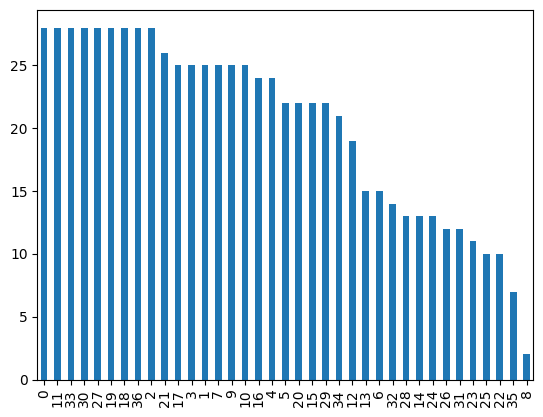

In [45]:
#Show number of windows for each segment to identify participants for discarding
data_participant = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Positive')]
data_participant = data_participant.reset_index(drop=True)
data_participant = data_participant.participant
data_participant.value_counts().plot.bar()

<AxesSubplot: >

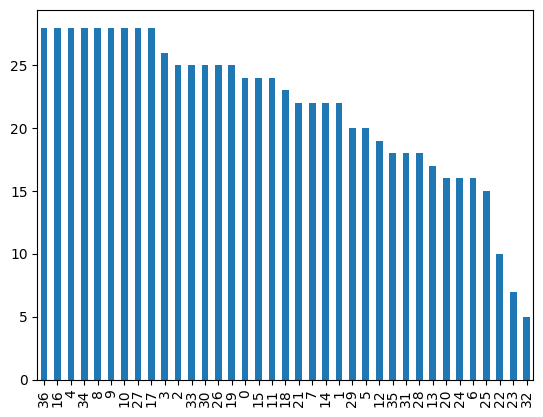

In [46]:
data_participant = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Negative')]
data_participant = data_participant.reset_index(drop=True)
data_participant = data_participant.participant
data_participant.value_counts().plot.bar()

<AxesSubplot: >

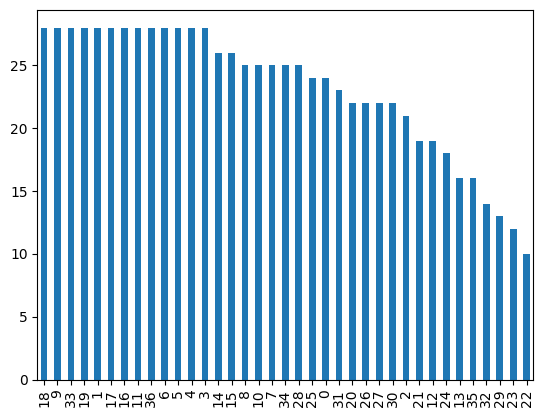

In [47]:
data_participant = df_feature_extraction.loc[(df_feature_extraction['segment'] == 'Neutral')]
data_participant = data_participant.reset_index(drop=True)
data_participant = data_participant.participant
data_participant.value_counts().plot.bar()

In [48]:
# Drop participants who have less than 10 windows in any segments (see plots above).
#participants_to_discard = [8, 22, 23, 25, 32, 33, 36, 14]
#participants_to_discard = [8, 22, 23, 25, 32, 33, 36, 14, 24, 28, 26, 31, 29]
# participants_to_discard = [33]
# df_feature_extraction.drop(df_feature_extraction.loc[df_feature_extraction['participant'].isin(participants_to_discard)].index, inplace=True)
# df_feature_extraction = df_feature_extraction.reset_index(drop=True)

In [50]:
len(list(set(data_participant)))

37

### 2.A) Barplots for features vs. affect segments

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

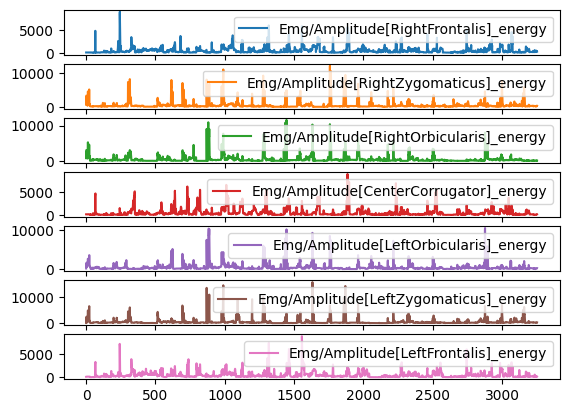

In [51]:
df_feature_extraction.loc[:,[str(x)+"_energy" for x in emg_colnames]].plot(subplots=True)

In [52]:
# Column names from feature extraction
HRV_SUBSET_FEATURES = ["HRV_MeanNN","HRV_SDNN","HRV_RMSSD","HRV_MedianNN", "HRV_IQRNN"]

In [53]:
# Average the feature values along the feature extraction windows
df_features_grouped_segment = df_feature_extraction.groupby(["participant","segment"]).mean().reset_index().drop(["i_window"], axis=1)
df_features_grouped_segment = df_features_grouped_segment.set_index(["segment"])
df_features_grouped_segment

,participant,w_center,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_MedianNN,HRV_IQRNN,Mean_BPM,Valence_mean,...,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
segment,,,,,,,,,,,,,,,,,,,,,
Negative,0,154.583333,839.691137,56.366737,51.342006,52.055388,835.000000,69.375000,71.550167,-1.457621,...,0.363102,0.261956,0.145507,0.035107,0.032309,0.043623,0.034585,0.089383,0.035635,0.183468
Neutral,0,164.166667,821.517938,66.109411,76.805778,77.889929,820.833333,70.000000,73.203345,0.031116,...,0.451319,0.456980,0.453609,0.034293,0.044911,0.084893,0.041132,0.235937,0.043997,0.209159
Positive,0,150.000000,816.050297,48.631672,39.569411,40.072712,815.714286,62.857143,73.606936,0.636010,...,0.955030,1.127690,0.292995,0.062933,0.049533,0.082235,0.030524,0.202260,0.037646,0.222566
Resting_Negative,0,50.280000,828.891573,41.136544,30.472484,30.783786,827.500000,46.875000,72.383087,-0.110190,...,0.572016,0.296298,0.313956,0.027304,0.034633,0.036125,0.029890,0.060920,0.027785,0.085931
Resting_Neutral,0,61.340000,805.743750,61.660389,55.605635,56.382883,799.000000,77.500000,74.512580,1.406826,...,0.197881,0.268884,0.137369,0.029395,0.035192,0.066214,0.033913,0.176794,0.040912,0.127876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Neutral,36,150.000000,652.800478,49.937288,41.874371,42.313173,646.785714,60.714286,92.046689,-0.264959,...,0.386039,0.454472,0.345055,0.238239,0.090879,0.158314,0.210583,0.048776,0.122560,0.222361
Positive,36,150.000000,661.262078,42.367154,35.375981,35.764966,660.000000,50.178571,90.809624,0.688255,...,0.543818,1.037766,0.279515,0.220745,0.118217,0.090484,0.132077,0.081355,0.205044,0.211213
Resting_Negative,36,65.000000,688.613475,50.287501,42.131335,42.639455,691.111111,68.888889,87.197598,0.961417,...,0.111695,0.406746,0.290855,0.034963,0.060291,0.134279,0.043945,0.027474,0.118554,0.033554


Functions to generate barplot

In [54]:
def convert_to_vertical_df(df_features):
    """
    Changes a dataframe to vertical version to make it compatible with
    seaborn plots.
    """
    # Change columns as rows to facilitate boxplots in seaborn
    df_vertical = None
    for c in df_features.columns:
        h_vertical_this = pd.DataFrame(data={
                                            "Affect Segment":df_features.index.values,
                                            "Feature Name":c,
                                            "Relative Variation":df_features[c].values
                                            })
        df_vertical = h_vertical_this if (df_vertical is None) else pd.concat([df_vertical, h_vertical_this], axis=0)
    return df_vertical


In [55]:
def plot_df_features_barplot(df_subset_features, ax=None, **kwargs):
    df_vertical = convert_to_vertical_df(df_subset_features)

    PALETTE_COLORS = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                      avdosvr.preprocessing.utils.enums.colourPaletteRGB.Relax.value]

    ax_plot = sns.barplot(data=df_vertical, ax=ax,
            x="Feature Name", y="Relative Variation", hue="Affect Segment",
            palette=PALETTE_COLORS,  **kwargs)
    return ax_plot

Heart rate

In [56]:
hr_feature_colnames = [ str(x)+"_mean" for x in avdosvr.preprocessing.COLNAMES_HR]
hr_feature_colnames

['HeartRate/Average_mean']

In [57]:
df_subset_features = df_features_grouped_segment.loc[:, hr_feature_colnames]
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_subset_features

,HeartRate/Average_mean
segment,
Negative,-0.242238
Neutral,0.026239
Positive,0.318635
Negative,-0.109114
Neutral,-0.021133
...,...
Neutral,-0.279569
Positive,-0.482919
Negative,-0.255731


In [58]:
new_colnames = [ x.split("/")[0] for x in df_subset_features.columns]
new_colnames

['HeartRate']

In [59]:
df_subset_features.columns = new_colnames

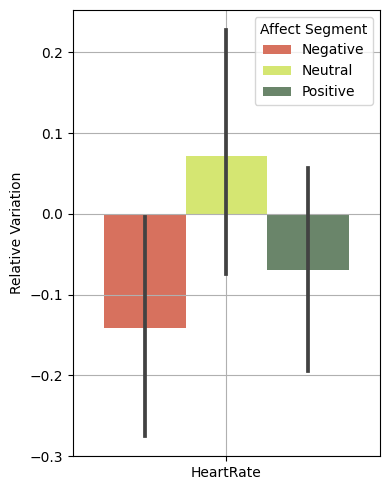

In [60]:
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-hr")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(4*NUM_COLS, 5*NUM_ROWS))

ax = axes
ax_i = plot_df_features_barplot(df_subset_features, ax=ax)
# ax_i.get_legend().remove()
ax.grid(True)
ax.set(xlabel=None)

plt.tight_layout()
plt.savefig(save_path_plot)

Heart Rate BPM

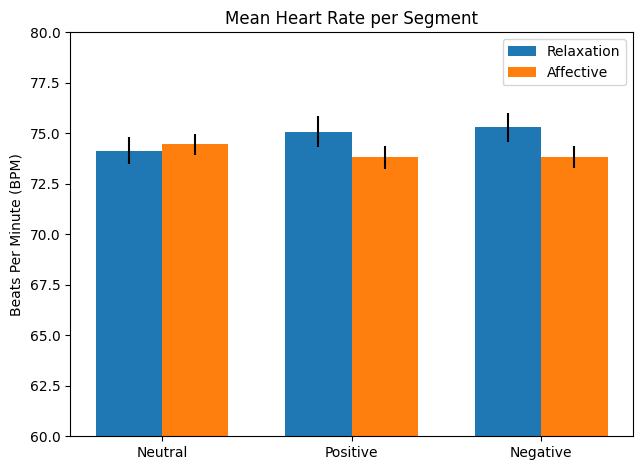

In [61]:
# Bar plot for Heart Rate (BPM)
df_subset_features = df_features_grouped_segment.loc[:, 'Mean_BPM']

segments = ['Neutral', 'Positive', 'Negative']
relax_means = [df_subset_features['Resting_Neutral'].mean(), 
               df_subset_features['Resting_Positive'].mean(), 
               df_subset_features['Resting_Negative'].mean()]

segment_means = [df_subset_features['Neutral'].mean(),
                 df_subset_features['Positive'].mean(),
                 df_subset_features['Negative'].mean()]

df_features_grouped_segment_se = df_feature_extraction.groupby(["participant","segment"]).sem().reset_index().drop(["i_window"], axis=1)
df_features_grouped_segment_se = df_features_grouped_segment_se.set_index(["segment"])
bpm_se = df_features_grouped_segment_se.loc[:, 'Mean_BPM']

relax_errors = [bpm_se['Resting_Neutral'].mean(), 
               bpm_se['Resting_Positive'].mean(), 
               bpm_se['Resting_Negative'].mean()]

segment_errors = [bpm_se['Neutral'].mean(),
                 bpm_se['Positive'].mean(),
                 bpm_se['Negative'].mean()]

x = np.arange(len(segments))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, relax_means, yerr=relax_errors, width=width, label='Relaxation')
rects2 = ax.bar(x + width/2, segment_means, yerr=segment_errors, width=width, label='Affective')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Beats Per Minute (BPM)')
ax.set_title('Mean Heart Rate per Segment')
ax.set_xticks(x, segments)
ax.legend()


fig.tight_layout()
plt.ylim(60,80)
save_path_plot = gen_path_plot(f"desc-barplot-hr-bpm")
plt.savefig(save_path_plot)
plt.show()

HR BPM Violin Plot

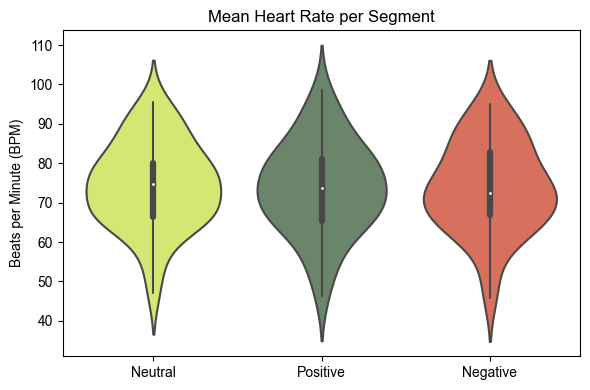

In [62]:
df_subset_features = df_features_grouped_segment.loc[:, 'Mean_BPM']
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_hr = pd.DataFrame(df_subset_features)

violin_plot_colours = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value]

violin_plot_order_rule = {
    "Neutral": 1,
    "Positive": 2,
    "Negative": 3
    }

def sort_violin_plot_order(series):
    """
    Must return one Series
    """
    return series.apply(lambda x: violin_plot_order_rule.get(x, 1000))

df_hr = df_hr.sort_values(by=['segment'], key=sort_violin_plot_order)

fig,axes = plt.subplots(1, 1, figsize=(6,4))
sns.set_style("whitegrid")
sns.violinplot(ax = axes, data=df_hr, x=df_hr.index, y="Mean_BPM", palette=violin_plot_colours).set(title='Mean Heart Rate per Segment')

plt.margins(x=0.05)
axes.set(xlabel=None)
plt.ylabel('Beats per Minute (BPM)')
fig.tight_layout()
save_path_plot = gen_path_plot(f"desc-violinplot-hr-bpm")
plt.savefig(save_path_plot)
plt.show()


In [63]:
neutral_bpm = df_subset_features['Neutral']
positive_bpm = df_subset_features['Positive']
negative_bpm = df_subset_features['Negative']

f_oneway(neutral_bpm, positive_bpm, negative_bpm)

F_onewayResult(statistic=0.03976584106390994, pvalue=0.961028507176159)

HRV

In [64]:
HRV_SUBSET_FEATURES

['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_MedianNN', 'HRV_IQRNN']

In [65]:
df_subset_features = df_features_grouped_segment.loc[:, HRV_SUBSET_FEATURES]
df_subset_features = df_subset_features.drop(["HRV_MeanNN","HRV_MedianNN"],axis=1)
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_subset_features

,HRV_SDNN,HRV_RMSSD,HRV_IQRNN
segment,,,
Negative,56.366737,51.342006,69.375000
Neutral,66.109411,76.805778,70.000000
Positive,48.631672,39.569411,62.857143
Negative,69.517459,83.324519,65.681818
Neutral,55.341728,62.671933,57.678571
...,...,...,...
Neutral,82.758885,118.736736,48.125000
Positive,59.859352,85.245039,55.000000
Negative,43.822328,36.431391,59.285714


In [66]:
#new_colnames = [ x.split("_")[1] for x in df_subset_features.columns]
new_colnames = ['sdnn', 'rmssd', 'sdsd']
new_colnames

['sdnn', 'rmssd', 'sdsd']

In [67]:
df_subset_features.columns = new_colnames

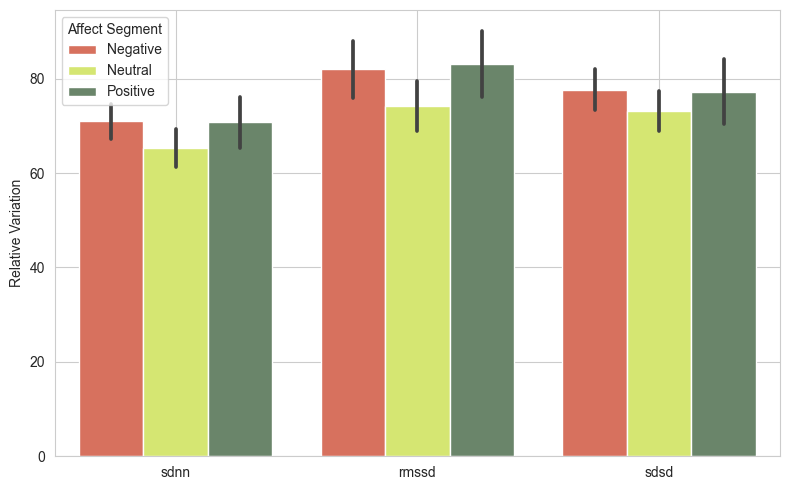

In [68]:
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-hrv")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(8*NUM_COLS, 5*NUM_ROWS))

ax = axes
ax_i = plot_df_features_barplot(df_subset_features, ax=ax, errorbar='se')
# ax_i.get_legend().remove()
ax.grid(True)
ax.set(xlabel=None)

plt.tight_layout()
plt.savefig(save_path_plot)

HRV Violin Plot

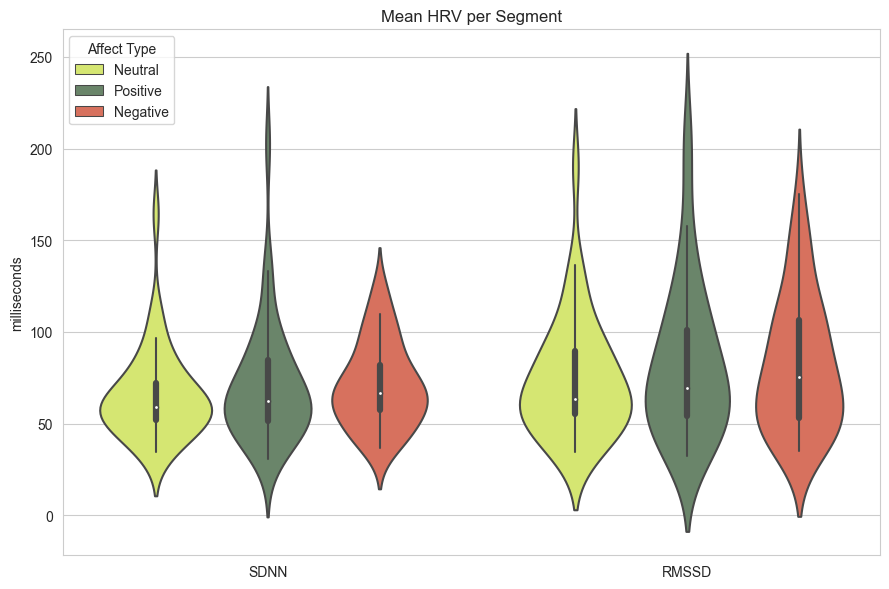

In [69]:
save_path_plot = gen_path_plot(f"desc-violinplot-hrv")
df_hrv = pd.DataFrame(df_subset_features)

violin_plot_colours = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value]

violin_plot_order_rule = {
    "Neutral": 1,
    "Positive": 2,
    "Negative": 3
    }

def sort_violin_plot_order(series):
    """
    Must return one Series
    """
    return series.apply(lambda x: violin_plot_order_rule.get(x, 1000))

df_hrv = df_hrv.sort_values(by=['segment'], key=sort_violin_plot_order)

hrv_sdnn = pd.DataFrame(df_hrv['sdnn']).reset_index(level=0)
hrv_sdnn = hrv_sdnn.rename(columns={"sdnn": "HRV"})
hrv_sdnn['type']='SDNN'

hrv_rmssd = pd.DataFrame(df_hrv['rmssd']).reset_index(level=0)
hrv_rmssd = hrv_rmssd.rename(columns={"rmssd": "HRV"})
hrv_rmssd['type']='RMSSD'

hrv_sdsd = pd.DataFrame(df_hrv['sdsd']).reset_index(level=0)
hrv_sdsd = hrv_sdsd.rename(columns={"sdsd": "HRV"})
hrv_sdsd['type']='SDSD'

#Leave out SDSD as it's less common
#hrv_combined = pd.concat([hrv_sdnn,hrv_rmssd,hrv_sdsd],ignore_index=True)
hrv_combined = pd.concat([hrv_sdnn,hrv_rmssd],ignore_index=True)

hrv_combined = hrv_combined.sort_values(by=['segment'], key=sort_violin_plot_order)

fig,axes = plt.subplots(1, 1, figsize=(9,6))
sns.set_style("whitegrid")
sns.violinplot(ax = axes, data=hrv_combined, x="type", y="HRV", width=0.8, palette=violin_plot_colours, hue='segment').set(title='Mean HRV per Segment')
plt.margins(x=0.05)
axes.set(xlabel=None)
plt.ylabel('milliseconds')
plt.legend(title='Affect Type',loc='upper left')

plt.tight_layout()
plt.savefig(save_path_plot)

In [70]:
sdnn_neutral = df_subset_features.loc['Neutral']['sdnn']
sdnn_positive = df_subset_features.loc['Positive']['sdnn']
sdnn_negative = df_subset_features.loc['Negative']['sdnn']

rmssd_neutral = df_subset_features.loc['Neutral']['rmssd']
rmssd_positive = df_subset_features.loc['Positive']['rmssd']
rmssd_negative = df_subset_features.loc['Negative']['rmssd']

print(f_oneway(sdnn_neutral, sdnn_positive, sdnn_negative))
print(f_oneway(rmssd_neutral, rmssd_positive, rmssd_negative))

F_onewayResult(statistic=0.5074890215130917, pvalue=0.6034336534468379)
F_onewayResult(statistic=0.6180878551049882, pvalue=0.540869483851613)


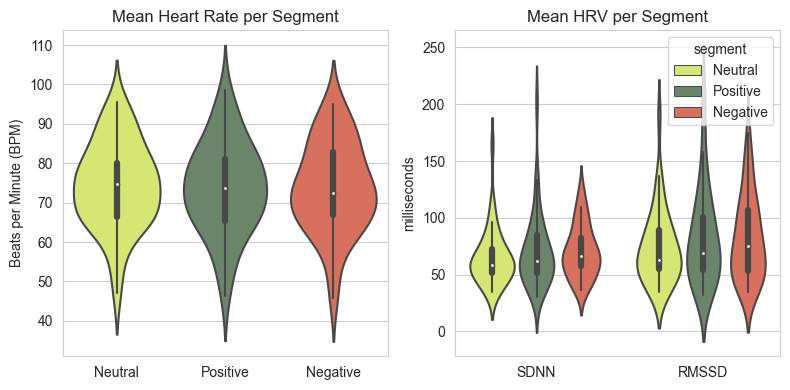

In [71]:
### Put this cell right before IMU plots

def violin_plot_hr(axes):
    df_subset_features = df_features_grouped_segment.loc[:, 'Mean_BPM']
    df_subset_features = df_subset_features.drop(['Resting_Negative'])
    df_subset_features = df_subset_features.drop(['Resting_Positive'])
    df_subset_features = df_subset_features.drop(['Resting_Neutral'])
    df_hr = pd.DataFrame(df_subset_features)

    violin_plot_colours = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                    avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                    avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value]

    violin_plot_order_rule = {
        "Neutral": 1,
        "Positive": 2,
        "Negative": 3
        }

    def sort_violin_plot_order(series):
        """
        Must return one Series
        """
        return series.apply(lambda x: violin_plot_order_rule.get(x, 1000))

    df_hr = df_hr.sort_values(by=['segment'], key=sort_violin_plot_order)

    # fig,axes = plt.subplots(1, 1, figsize=(6,4))
    sns.set_style("whitegrid")
    sns.violinplot(ax = axes, data=df_hr, x=df_hr.index, y="Mean_BPM", palette=violin_plot_colours).set(title='Mean Heart Rate per Segment')
    axes.set(xlabel=None)
    axes.set(ylabel='Beats per Minute (BPM)')
    
    return axes

def violin_plot_hrv(axes):
    df_subset_features = df_features_grouped_segment.loc[:, HRV_SUBSET_FEATURES]
    df_subset_features = df_subset_features.drop(["HRV_MeanNN","HRV_MedianNN"],axis=1)
    df_subset_features = df_subset_features.drop(['Resting_Negative'])
    df_subset_features = df_subset_features.drop(['Resting_Positive'])
    df_subset_features = df_subset_features.drop(['Resting_Neutral'])
    # df_subset_features

    new_colnames = ['sdnn', 'rmssd', 'sdsd']
    df_subset_features.columns = new_colnames

    df_hrv = pd.DataFrame(df_subset_features)

    violin_plot_colours = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                    avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                    avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value]

    violin_plot_order_rule = {
        "Neutral": 1,
        "Positive": 2,
        "Negative": 3
        }

    def sort_violin_plot_order(series):
        """
        Must return one Series
        """
        return series.apply(lambda x: violin_plot_order_rule.get(x, 1000))

    df_hrv = df_hrv.sort_values(by=['segment'], key=sort_violin_plot_order)

    hrv_sdnn = pd.DataFrame(df_hrv['sdnn']).reset_index(level=0)
    hrv_sdnn = hrv_sdnn.rename(columns={"sdnn": "HRV"})
    hrv_sdnn['type']='SDNN'

    hrv_rmssd = pd.DataFrame(df_hrv['rmssd']).reset_index(level=0)
    hrv_rmssd = hrv_rmssd.rename(columns={"rmssd": "HRV"})
    hrv_rmssd['type']='RMSSD'

    hrv_sdsd = pd.DataFrame(df_hrv['sdsd']).reset_index(level=0)
    hrv_sdsd = hrv_sdsd.rename(columns={"sdsd": "HRV"})
    hrv_sdsd['type']='SDSD'

    #Leave out SDSD as it's less common
    #hrv_combined = pd.concat([hrv_sdnn,hrv_rmssd,hrv_sdsd],ignore_index=True)
    hrv_combined = pd.concat([hrv_sdnn,hrv_rmssd],ignore_index=True)

    hrv_combined = hrv_combined.sort_values(by=['segment'], key=sort_violin_plot_order)

    # fig,axes = plt.subplots(1, 1, figsize=(9,6))
    sns.set_style("whitegrid")
    sns.violinplot(ax = axes, data=hrv_combined, x="type", y="HRV", width=0.8, palette=violin_plot_colours, hue='segment').set(title='Mean HRV per Segment')
    # plt.margins(x=0.05)
    axes.set(xlabel=None)
    axes.set(ylabel='milliseconds')
    # plt.legend(title='Affect Type',loc='upper left')


fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

violin_plot_hr(axes[0])
violin_plot_hrv(axes[1])

plt.margins(x=0.05)

fig.tight_layout()
save_path_plot = gen_path_plot(f"desc-violinplot-hr-hrv-combined")
plt.savefig(save_path_plot)
plt.show()

IMU

In [72]:
imu_feature_colnames = [ str(x)+"_rms" for x in imu_colnames]
imu_feature_colnames

['Accelerometer/Raw.x_rms',
 'Accelerometer/Raw.y_rms',
 'Accelerometer/Raw.z_rms',
 'Magnetometer/Raw.x_rms',
 'Magnetometer/Raw.y_rms',
 'Magnetometer/Raw.z_rms',
 'Gyroscope/Raw.x_rms',
 'Gyroscope/Raw.y_rms',
 'Gyroscope/Raw.z_rms']

In [73]:
df_subset_features = df_features_grouped_segment.loc[:, imu_feature_colnames]
# df_subset_features = df_subset_features.drop(["HRV_MeanNN","HRV_MedianNN"],axis=1)
df_subset_features

,Accelerometer/Raw.x_rms,Accelerometer/Raw.y_rms,Accelerometer/Raw.z_rms,Magnetometer/Raw.x_rms,Magnetometer/Raw.y_rms,Magnetometer/Raw.z_rms,Gyroscope/Raw.x_rms,Gyroscope/Raw.y_rms,Gyroscope/Raw.z_rms
segment,,,,,,,,,
Negative,0.823286,0.398064,0.873042,0.950109,0.660418,0.852120,0.343702,0.642577,0.408968
Neutral,0.516255,1.214434,0.687202,0.753634,1.296681,1.023062,0.755067,0.735857,0.700612
Positive,0.690426,1.149984,0.698336,0.722688,0.915169,0.824460,0.406854,0.695795,0.512493
Resting_Negative,0.620696,0.964684,0.468414,0.626494,0.646516,0.584382,0.270721,0.515196,0.339441
Resting_Neutral,1.217422,0.392644,1.469870,1.391805,0.632098,1.216234,0.386684,0.607864,0.510866
...,...,...,...,...,...,...,...,...,...
Neutral,0.988431,0.407496,1.018750,1.085857,0.721136,0.927233,0.587204,0.504874,0.454508
Positive,0.690811,1.438861,0.690266,0.632267,1.103374,0.872887,0.467247,0.491744,0.311376
Resting_Negative,0.730869,0.659467,0.850660,0.803060,0.887078,0.979719,0.387883,0.418893,0.285875


In [74]:
new_colnames = [ str(x)[:3]+"/"+x.split(".")[1][:1] for x in df_subset_features.columns]
df_subset_features.columns = new_colnames
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_subset_features

,Acc/x,Acc/y,Acc/z,Mag/x,Mag/y,Mag/z,Gyr/x,Gyr/y,Gyr/z
segment,,,,,,,,,
Negative,0.823286,0.398064,0.873042,0.950109,0.660418,0.852120,0.343702,0.642577,0.408968
Neutral,0.516255,1.214434,0.687202,0.753634,1.296681,1.023062,0.755067,0.735857,0.700612
Positive,0.690426,1.149984,0.698336,0.722688,0.915169,0.824460,0.406854,0.695795,0.512493
Negative,0.381587,0.507134,0.347362,0.520217,0.585510,0.364441,0.229789,0.399075,0.305214
Neutral,0.414812,0.624292,0.372517,0.561601,0.652137,0.464913,0.556104,0.497065,0.519065
...,...,...,...,...,...,...,...,...,...
Neutral,0.429282,0.896187,0.470032,0.689091,0.933178,0.688907,0.397228,0.374024,0.373414
Positive,0.524122,0.573786,0.530566,0.391522,0.751124,0.739113,0.337920,0.334287,0.376886
Negative,0.935486,0.829586,0.879649,0.972722,0.937816,0.894674,0.542684,0.592305,0.350277


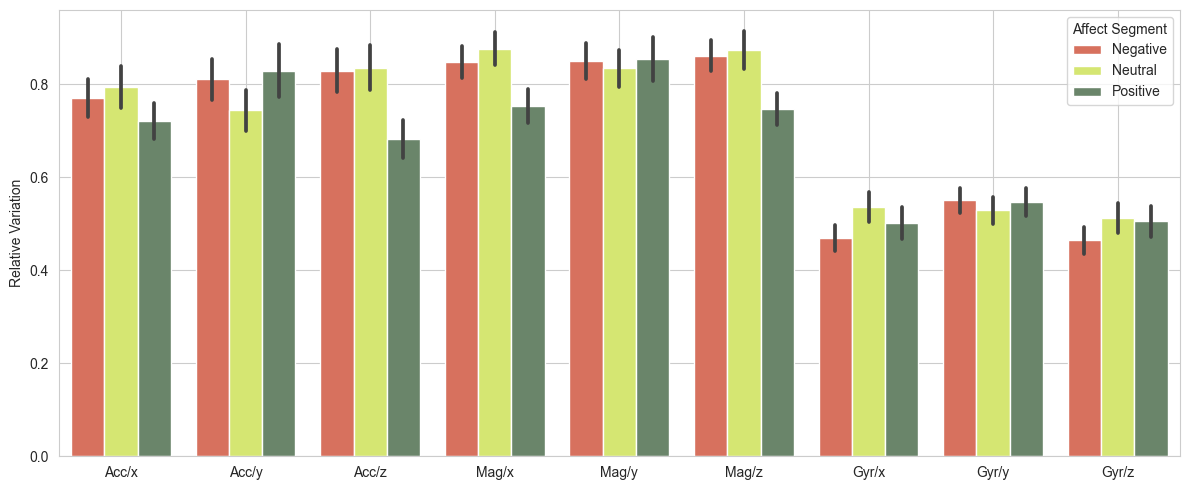

In [75]:
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-imu")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(12*NUM_COLS, 5*NUM_ROWS))

ax = axes
ax_i = plot_df_features_barplot(df_subset_features, ax=ax, errorbar='se')
# ax_i.get_legend().remove()
ax.grid(True)
ax.set(xlabel=None)

plt.tight_layout()
plt.savefig(save_path_plot)

In [76]:
#ANOVA TESTS
acc_x_neutral = df_subset_features.loc['Neutral']['Acc/x']
acc_x_positive = df_subset_features.loc['Positive']['Acc/x']
acc_x_negative = df_subset_features.loc['Negative']['Acc/x']

acc_y_neutral = df_subset_features.loc['Neutral']['Acc/y']
acc_y_positive = df_subset_features.loc['Positive']['Acc/y']
acc_y_negative = df_subset_features.loc['Negative']['Acc/y']

acc_z_neutral = df_subset_features.loc['Neutral']['Acc/z']
acc_z_positive = df_subset_features.loc['Positive']['Acc/z']
acc_z_negative = df_subset_features.loc['Negative']['Acc/z']

mag_x_neutral = df_subset_features.loc['Neutral']['Mag/x']
mag_x_positive = df_subset_features.loc['Positive']['Mag/x']
mag_x_negative = df_subset_features.loc['Negative']['Mag/x']

mag_y_neutral = df_subset_features.loc['Neutral']['Mag/y']
mag_y_positive = df_subset_features.loc['Positive']['Mag/y']
mag_y_negative = df_subset_features.loc['Negative']['Mag/y']

mag_z_neutral = df_subset_features.loc['Neutral']['Mag/z']
mag_z_positive = df_subset_features.loc['Positive']['Mag/z']
mag_z_negative = df_subset_features.loc['Negative']['Mag/z']

gyr_x_neutral = df_subset_features.loc['Neutral']['Gyr/x']
gyr_x_positive = df_subset_features.loc['Positive']['Gyr/x']
gyr_x_negative = df_subset_features.loc['Negative']['Gyr/x']

gyr_y_neutral = df_subset_features.loc['Neutral']['Gyr/y']
gyr_y_positive = df_subset_features.loc['Positive']['Gyr/y']
gyr_y_negative = df_subset_features.loc['Negative']['Gyr/y']

gyr_z_neutral = df_subset_features.loc['Neutral']['Gyr/z']
gyr_z_positive = df_subset_features.loc['Positive']['Gyr/z']
gyr_z_negative = df_subset_features.loc['Negative']['Gyr/z']

print('Acc_X: ' + str(f_oneway(acc_x_neutral, acc_x_positive, acc_x_negative)))
print('Acc_Y: ' + str(f_oneway(acc_y_neutral, acc_y_positive, acc_y_negative)))
print('Acc_Z: ' + str(f_oneway(acc_z_neutral, acc_z_positive, acc_z_negative)))
print('Mag_X: ' + str(f_oneway(mag_x_neutral, mag_x_positive, mag_x_negative)))
print('Mag_Y: ' + str(f_oneway(mag_y_neutral, mag_y_positive, mag_y_negative)))
print('Mag_Z ' + str(f_oneway(mag_z_neutral, mag_z_positive, mag_z_negative)))
print('Gyr_X: ' + str(f_oneway(gyr_x_neutral, gyr_x_positive, gyr_x_negative)))
print('Gyr_Y: ' + str(f_oneway(gyr_y_neutral, gyr_y_positive, gyr_y_negative)))
print('Gyr_Z: ' + str(f_oneway(gyr_z_neutral, gyr_z_positive, gyr_z_negative)))

Acc_X: F_onewayResult(statistic=0.812484748323773, pvalue=0.44644768736765816)
Acc_Y: F_onewayResult(statistic=0.826565135337966, pvalue=0.44029825065285744)
Acc_Z: F_onewayResult(statistic=3.7525700667660633, pvalue=0.02657124988586083)
Mag_X: F_onewayResult(statistic=3.372484549277063, pvalue=0.03795469591937288)
Mag_Y: F_onewayResult(statistic=0.06119170807454281, pvalue=0.9406754822562138)
Mag_Z F_onewayResult(statistic=3.6770958355648036, pvalue=0.028515452094397938)
Gyr_X: F_onewayResult(statistic=1.1199956466257093, pvalue=0.33004077791904557)
Gyr_Y: F_onewayResult(statistic=0.15466551190666644, pvalue=0.8568911002902526)
Gyr_Z: F_onewayResult(statistic=0.6679207856535918, pvalue=0.5148787666461161)


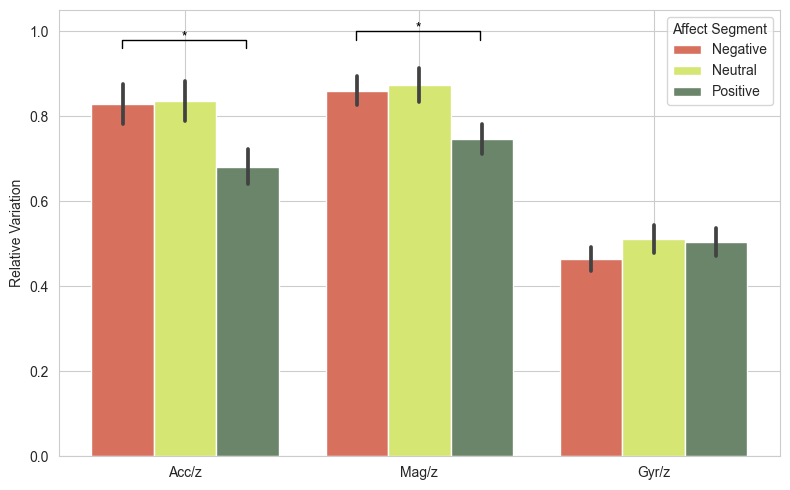

In [77]:
# IMU only Z axis
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-imu-z-axis")

df_subset_features = df_subset_features[['Acc/z', 'Mag/z', 'Gyr/z']]

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(8*NUM_COLS, 5*NUM_ROWS))

ax = axes
ax_i = plot_df_features_barplot(df_subset_features, ax=ax, errorbar='se')
# ax_i.get_legend().remove()
ax.grid(True)
ax.set(xlabel=None)

### Acc Z axis Pos - Neg
plt.plot([-0.27,-0.27, 0.26, 0.26], [0.96, 0.98, 0.98, 0.96], linewidth=1, color='k')
plt.text((-0.27+0.26)*.5, 0.97, "*", ha='center', va='bottom', color='k')

### Mag Z axis Pos - Neg
plt.plot([0.73,0.73, 1.26, 1.26], [0.98, 1, 1, 0.98], linewidth=1, color='k')
plt.text((0.73+1.26)*.5, 0.99, "*", ha='center', va='bottom', color='k')

plt.tight_layout()
plt.savefig(save_path_plot)

In [78]:
# PLanned t tests

##Acc Z-axis
print('Acc Z-axis')
print('Pos-Neu: ' + str(stats.ttest_rel(acc_z_positive, acc_z_neutral, alternative='greater')))
print('Pos-Neg: ' + str(stats.ttest_rel(acc_z_positive, acc_z_negative, alternative='less')))
print('Neg-Neu: ' + str(stats.ttest_rel(acc_z_negative, acc_z_neutral,  alternative='greater')))

##Acc Z-axis
print('\nMag Z-axis')
print('Pos-Neu: ' + str(stats.ttest_rel(mag_z_positive, mag_z_neutral, alternative='greater')))
print('Pos-Neg: ' + str(stats.ttest_rel(mag_z_positive, mag_z_negative, alternative='less')))
print('Neg-Neu: ' + str(stats.ttest_rel(mag_z_negative, mag_z_neutral, alternative='greater')))

##Acc Z-axis
print('\nGyr Z-axis')
print('Pos-Neu: ' + str(stats.ttest_rel(gyr_z_positive, gyr_z_neutral, alternative='greater')))
print('Pos-Neg: ' + str(stats.ttest_rel(gyr_z_positive, gyr_z_negative, alternative='less')))
print('Neg-Neu: ' + str(stats.ttest_rel(gyr_z_negative, gyr_z_neutral, alternative='greater')))

Acc Z-axis
Pos-Neu: TtestResult(statistic=-2.2837005452579504, pvalue=0.9858034976078516, df=36)
Pos-Neg: TtestResult(statistic=-2.530507018992898, pvalue=0.007952085426980603, df=36)
Neg-Neu: TtestResult(statistic=-0.08015740240978751, pvalue=0.5317219882187195, df=36)

Mag Z-axis
Pos-Neu: TtestResult(statistic=-2.301235877073797, pvalue=0.9863620034067953, df=36)
Pos-Neg: TtestResult(statistic=-2.4009308554208832, pvalue=0.010822174981215965, df=36)
Neg-Neu: TtestResult(statistic=-0.19969659274048232, pvalue=0.5785791900504782, df=36)

Gyr Z-axis
Pos-Neu: TtestResult(statistic=-0.17173093802412048, pvalue=0.567694605732699, df=36)
Pos-Neg: TtestResult(statistic=1.5138592799147266, pvalue=0.9306037374233799, df=36)
Neg-Neu: TtestResult(statistic=-1.461253555755432, pvalue=0.9236899536883665, df=36)


In [79]:
# IMU NEW


EMG Amplitude

In [80]:
emg_feature_colnames = [ str(x)+"_rms" for x in emg_colnames]
emg_feature_colnames

['Emg/Amplitude[RightFrontalis]_rms',
 'Emg/Amplitude[RightZygomaticus]_rms',
 'Emg/Amplitude[RightOrbicularis]_rms',
 'Emg/Amplitude[CenterCorrugator]_rms',
 'Emg/Amplitude[LeftOrbicularis]_rms',
 'Emg/Amplitude[LeftZygomaticus]_rms',
 'Emg/Amplitude[LeftFrontalis]_rms']

In [81]:
df_subset_features = df_features_grouped_segment.loc[:, emg_feature_colnames]
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_subset_features

,Emg/Amplitude[RightFrontalis]_rms,Emg/Amplitude[RightZygomaticus]_rms,Emg/Amplitude[RightOrbicularis]_rms,Emg/Amplitude[CenterCorrugator]_rms,Emg/Amplitude[LeftOrbicularis]_rms,Emg/Amplitude[LeftZygomaticus]_rms,Emg/Amplitude[LeftFrontalis]_rms
segment,,,,,,,
Negative,0.176107,0.290701,0.316833,0.228970,0.363102,0.261956,0.145507
Neutral,0.330393,0.340629,0.487781,0.490021,0.451319,0.456980,0.453609
Positive,0.189390,1.063023,1.151048,0.302279,0.955030,1.127690,0.292995
Negative,0.368576,0.309004,0.314823,0.297190,0.270290,0.374189,0.478907
Neutral,0.282719,0.358775,0.332328,0.163994,0.277129,0.369459,0.313787
...,...,...,...,...,...,...,...
Neutral,0.248133,0.455483,0.390666,0.149549,0.275108,0.573371,0.283185
Positive,0.230770,0.699660,0.422427,0.169032,0.269023,0.788250,0.241763
Negative,0.676781,0.337476,0.192281,0.695516,0.275308,0.373781,0.558081


In [82]:
new_colnames = [ x.split("[")[1].split("]")[0] for x in df_subset_features.columns]
new_colnames
df_subset_features.columns = new_colnames
rearranged_emg_colnames = ['LeftFrontalis', 'RightFrontalis', 'CenterCorrugator', 'LeftOrbicularis', 
                           'RightOrbicularis', 'LeftZygomaticus', 'RightZygomaticus']
df_subset_features = df_subset_features[rearranged_emg_colnames]

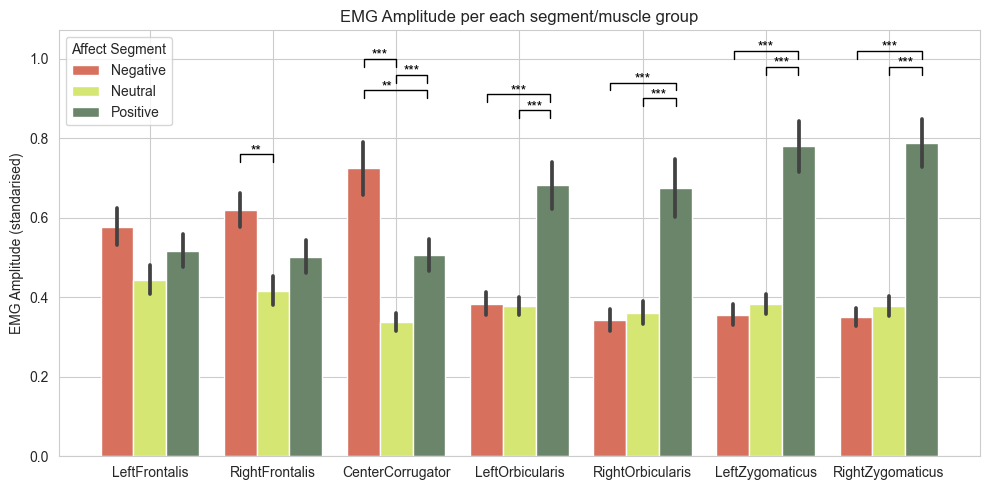

In [83]:
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-emgAmplitude")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(10*NUM_COLS, 5*NUM_ROWS))

PALETTE_COLORS = [avdosvr.preprocessing.utils.enums.colourPaletteRGB.Negative.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Neutral.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Positive.value,
                  avdosvr.preprocessing.utils.enums.colourPaletteRGB.Relax.value]

df_vertical = convert_to_vertical_df(df_subset_features)

ax = axes
ax_i = ax_plot = sns.barplot(data=df_vertical, ax=ax, x="Feature Name", y="Relative Variation", hue="Affect Segment", 
                      palette=PALETTE_COLORS, errorbar='se').set(title='EMG Amplitude per each segment/muscle group')

# Signififance annotations

## Positive - Neutral
### CCorrugator
plt.plot([2,2, 2.25, 2.25], [0.94, 0.96, 0.96, 0.94], linewidth=1, color='k')
plt.text((2+2.25)*.5, 0.95, "***", ha='center', va='bottom', color='k')

### LOrbicularis
plt.plot([3,3, 3.25, 3.25], [0.85, 0.87, 0.87, 0.85], linewidth=1, color='k')
plt.text((3+3.25)*.5, 0.86, "***", ha='center', va='bottom', color='k')

### ROrbicularis
plt.plot([4,4, 4.27, 4.27], [0.88, 0.90, 0.90, 0.88], linewidth=1, color='k')
plt.text((4+4.27)*.5, 0.89, "***", ha='center', va='bottom', color='k')

### Lzygomaticus
plt.plot([5,5, 5.26, 5.26], [0.96, 0.98, 0.98, 0.96], linewidth=1, color='k')
plt.text((5+5.26)*.5, 0.97, "***", ha='center', va='bottom', color='k')

### Rzygomaticus
plt.plot([6,6, 6.27, 6.27], [0.96, 0.98, 0.98, 0.96], linewidth=1, color='k')
plt.text((6+6.27)*.5, 0.97, "***", ha='center', va='bottom', color='k')



## Positive - Negative
### CCorrugator
plt.plot([1.74,1.74, 2.25, 2.25], [0.9, 0.92, 0.92, 0.9], linewidth=1, color='k')
plt.text((1.6+2.25)*.5, 0.91, "**", ha='center', va='bottom', color='k')

### LOrbicularis
plt.plot([2.74,2.74, 3.25, 3.25], [0.89, 0.91, 0.91, 0.89], linewidth=1, color='k')
plt.text((2.74+3.25)*.5, 0.90, "***", ha='center', va='bottom', color='k')

### ROrbicularis
plt.plot([3.74,3.74, 4.27, 4.27], [0.92, 0.94, 0.94, 0.92], linewidth=1, color='k')
plt.text((3.74+4.27)*.5, 0.93, "***", ha='center', va='bottom', color='k')

### Lzygomaticus
plt.plot([4.74,4.74, 5.26, 5.26], [1, 1.02, 1.02, 1], linewidth=1, color='k')
plt.text((4.74+5.26)*.5, 1.01, "***", ha='center', va='bottom', color='k')

### Rzygomaticus
plt.plot([5.74,5.74, 6.27, 6.27], [1, 1.02, 1.02, 1], linewidth=1, color='k')
plt.text((5.74+6.27)*.5, 1.01, "***", ha='center', va='bottom', color='k')



## Positive - Negative
### Rfrontalis
plt.plot([0.73,0.73, 1, 1], [0.74, 0.76, 0.76, 0.74], linewidth=1, color='k')
plt.text((0.73+1)*.5, 0.75, "**", ha='center', va='bottom', color='k')

### CCorrugator
plt.plot([1.74,1.74, 2, 2], [0.98, 1, 1, 0.98], linewidth=1, color='k')
plt.text((1.74+2)*.5, 0.99, "***", ha='center', va='bottom', color='k')


ax.grid(True)
ax.set(xlabel=None)
plt.ylabel('EMG Amplitude (standarised)')



plt.tight_layout()
plt.savefig(save_path_plot)

In [84]:
#ANOVA TESTS
left_frontalis_neutral = df_subset_features.loc['Neutral']['LeftFrontalis']
left_frontalis_positive = df_subset_features.loc['Positive']['LeftFrontalis']
left_frontalis_negative = df_subset_features.loc['Negative']['LeftFrontalis']

right_frontalis_neutral = df_subset_features.loc['Neutral']['RightFrontalis']
right_frontalis_positive = df_subset_features.loc['Positive']['RightFrontalis']
right_frontalis_negative = df_subset_features.loc['Negative']['RightFrontalis']

center_corrugator_neutral = df_subset_features.loc['Neutral']['CenterCorrugator']
center_corrugator_positive = df_subset_features.loc['Positive']['CenterCorrugator']
center_corrugator_negative = df_subset_features.loc['Negative']['CenterCorrugator']

left_orbicularis_neutral = df_subset_features.loc['Neutral']['LeftOrbicularis']
left_orbicularis_positive = df_subset_features.loc['Positive']['LeftOrbicularis']
left_orbicularis_negative = df_subset_features.loc['Negative']['LeftOrbicularis']

right_orbicularis_neutral = df_subset_features.loc['Neutral']['RightOrbicularis']
right_orbicularis_positive = df_subset_features.loc['Positive']['RightOrbicularis']
right_orbicularis_negative = df_subset_features.loc['Negative']['RightOrbicularis']

left_zygomaticus_neutral = df_subset_features.loc['Neutral']['LeftZygomaticus']
left_zygomaticus_positive = df_subset_features.loc['Positive']['LeftZygomaticus']
left_zygomaticus_negative = df_subset_features.loc['Negative']['LeftZygomaticus']

right_zygomaticus_neutral = df_subset_features.loc['Neutral']['RightZygomaticus']
right_zygomaticus_positive = df_subset_features.loc['Positive']['RightZygomaticus']
right_zygomaticus_negative = df_subset_features.loc['Negative']['RightZygomaticus']

print('Lfrontalis: ' + str(f_oneway(left_frontalis_neutral, left_frontalis_positive, left_frontalis_negative)))
print('Rfrontalis: ' + str(f_oneway(right_frontalis_neutral, right_frontalis_positive, right_frontalis_negative)))
print('Ccorrugator: ' + str(f_oneway(center_corrugator_neutral, center_corrugator_positive, center_corrugator_negative)))
print('LOrbicularis: ' + str(f_oneway(left_orbicularis_neutral, left_orbicularis_positive, left_orbicularis_negative)))
print('ROrbicularis: ' + str(f_oneway(right_orbicularis_neutral, right_orbicularis_positive, right_orbicularis_negative)))
print('Lzygomaticus: ' + str(f_oneway(left_zygomaticus_neutral, left_zygomaticus_positive, left_zygomaticus_negative)))
print('Rzygomaticus: ' + str(f_oneway(right_zygomaticus_neutral, right_zygomaticus_positive, right_zygomaticus_negative)))

Lfrontalis: F_onewayResult(statistic=2.5684718276515808, pvalue=0.08132852815261356)
Rfrontalis: F_onewayResult(statistic=6.493086726153469, pvalue=0.002173465632917325)
Ccorrugator: F_onewayResult(statistic=16.92459506072502, pvalue=4.0386138087326333e-07)
LOrbicularis: F_onewayResult(statistic=18.586567204365824, pvalue=1.1561790509258737e-07)
ROrbicularis: F_onewayResult(statistic=15.13146966705485, pvalue=1.6097943141579496e-06)
Lzygomaticus: F_onewayResult(statistic=30.979601429380565, pvalue=2.3241801055732542e-11)
Rzygomaticus: F_onewayResult(statistic=37.51371268551224, pvalue=4.2560780645687915e-13)


In [85]:
#T-TESTS

bonferroni_correction = 7
decimal_places = 3
print('Bonferroni correction for 7 tests applied. P value multiplied by 7.\n')
#Positive - Neutral
Pos_Neu_LF_test_value, Pos_Neu_LF_p_value, = stats.ttest_rel(left_frontalis_positive, left_frontalis_neutral)
Pos_Neu_RF_test_value, Pos_Neu_RF_p_value, = stats.ttest_rel(right_frontalis_positive, right_frontalis_neutral)
Pos_Neu_CC_test_value, Pos_Neu_CC_p_value, = stats.ttest_rel(center_corrugator_positive, center_corrugator_neutral)
Pos_Neu_LO_test_value, Pos_Neu_LO_p_value, = stats.ttest_rel(left_orbicularis_positive, left_orbicularis_neutral)
Pos_Neu_RO_test_value, Pos_Neu_RO_p_value, = stats.ttest_rel(right_orbicularis_positive, right_orbicularis_neutral)
Pos_Neu_LZ_test_value, Pos_Neu_LZ_p_value, = stats.ttest_rel(left_zygomaticus_positive, left_zygomaticus_neutral)
Pos_Neu_RZ_test_value, Pos_Neu_RZ_p_value, = stats.ttest_rel(right_zygomaticus_positive, right_zygomaticus_neutral)

print('Positive - Neutral')
print('Lfrontalis - statistic=' + str(round(Pos_Neu_LF_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_LF_p_value*bonferroni_correction, decimal_places)))
print('Rfrontalis - statistic=' + str(round(Pos_Neu_RF_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_RF_p_value*bonferroni_correction, decimal_places)))
print('Ccorrugator - statistic=' + str(round(Pos_Neu_CC_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_CC_p_value*bonferroni_correction, decimal_places)))
print('LOrbicularis - statistic=' + str(round(Pos_Neu_LO_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_LO_p_value*bonferroni_correction, decimal_places)))
print('ROrbicularis - statistic=' + str(round(Pos_Neu_RO_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_RO_p_value*bonferroni_correction, decimal_places)))
print('Lzygomaticus - statistic=' + str(round(Pos_Neu_LZ_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_LZ_p_value*bonferroni_correction, decimal_places)))
print('Rzygomaticus - statistic=' + str(round(Pos_Neu_RZ_test_value, decimal_places)) + ', p=' + str(round(Pos_Neu_RZ_p_value*bonferroni_correction, decimal_places)))

#Positive - Negative
Pos_Neg_LF_test_value, Pos_Neg_LF_p_value, = stats.ttest_rel(left_frontalis_positive, left_frontalis_negative)
Pos_Neg_RF_test_value, Pos_Neg_RF_p_value, = stats.ttest_rel(right_frontalis_positive, right_frontalis_negative)
Pos_Neg_CC_test_value, Pos_Neg_CC_p_value, = stats.ttest_rel(center_corrugator_positive, center_corrugator_negative)
Pos_Neg_LO_test_value, Pos_Neg_LO_p_value, = stats.ttest_rel(left_orbicularis_positive, left_orbicularis_negative)
Pos_Neg_RO_test_value, Pos_Neg_RO_p_value, = stats.ttest_rel(right_orbicularis_positive, right_orbicularis_negative)
Pos_Neg_LZ_test_value, Pos_Neg_LZ_p_value, = stats.ttest_rel(left_zygomaticus_positive, left_zygomaticus_negative)
Pos_Neg_RZ_test_value, Pos_Neg_RZ_p_value, = stats.ttest_rel(right_zygomaticus_positive, right_zygomaticus_negative)

print('\nPositive - Negative')
print('Lfrontalis - statistic=' + str(round(Pos_Neg_LF_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_LF_p_value*bonferroni_correction, decimal_places)))
print('Rfrontalis - statistic=' + str(round(Pos_Neg_RF_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_RF_p_value*bonferroni_correction, decimal_places)))
print('Ccorrugator - statistic=' + str(round(Pos_Neg_CC_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_CC_p_value*bonferroni_correction, decimal_places)))
print('LOrbicularis - statistic=' + str(round(Pos_Neg_LO_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_LO_p_value*bonferroni_correction, decimal_places)))
print('ROrbicularis - statistic=' + str(round(Pos_Neg_RO_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_RO_p_value*bonferroni_correction, decimal_places)))
print('Lzygomaticus - statistic=' + str(round(Pos_Neg_LZ_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_LZ_p_value*bonferroni_correction, decimal_places)))
print('Rzygomaticus - statistic=' + str(round(Pos_Neg_RZ_test_value, decimal_places)) + ', p=' + str(round(Pos_Neg_RZ_p_value*bonferroni_correction, decimal_places)))

#Negative - Neutral
Neg_Neu_LF_test_value, Neg_Neu_LF_p_value, = stats.ttest_rel(left_frontalis_negative, left_frontalis_neutral)
Neg_Neu_RF_test_value, Neg_Neu_RF_p_value, = stats.ttest_rel(right_frontalis_negative, right_frontalis_neutral)
Neg_Neu_CC_test_value, Neg_Neu_CC_p_value, = stats.ttest_rel(center_corrugator_negative, center_corrugator_neutral)
Neg_Neu_LO_test_value, Neg_Neu_LO_p_value, = stats.ttest_rel(left_orbicularis_negative, left_orbicularis_neutral)
Neg_Neu_RO_test_value, Neg_Neu_RO_p_value, = stats.ttest_rel(right_orbicularis_negative, right_orbicularis_neutral)
Neg_Neu_LZ_test_value, Neg_Neu_LZ_p_value, = stats.ttest_rel(left_zygomaticus_negative, left_zygomaticus_neutral)
Neg_Neu_RZ_test_value, Neg_Neu_RZ_p_value, = stats.ttest_rel(right_zygomaticus_negative, right_zygomaticus_neutral)

print('\nNegative - Neutral')
print('Lfrontalis - statistic=' + str(round(Neg_Neu_LF_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_LF_p_value*bonferroni_correction, decimal_places)))
print('Rfrontalis - statistic=' + str(round(Neg_Neu_RF_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_RF_p_value*bonferroni_correction, decimal_places)))
print('Ccorrugator - statistic=' + str(round(Neg_Neu_CC_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_CC_p_value*bonferroni_correction, decimal_places)))
print('LOrbicularis - statistic=' + str(round(Neg_Neu_LO_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_LO_p_value*bonferroni_correction, decimal_places)))
print('ROrbicularis - statistic=' + str(round(Neg_Neu_RO_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_RO_p_value*bonferroni_correction, decimal_places)))
print('Lzygomaticus - statistic=' + str(round(Neg_Neu_LZ_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_LZ_p_value*bonferroni_correction, decimal_places)))
print('Rzygomaticus - statistic=' + str(round(Neg_Neu_RZ_test_value, decimal_places)) + ', p=' + str(round(Neg_Neu_RZ_p_value*bonferroni_correction, decimal_places)))


Bonferroni correction for 7 tests applied. P value multiplied by 7.

Positive - Neutral
Lfrontalis - statistic=2.08, p=0.313
Rfrontalis - statistic=2.172, p=0.256
Ccorrugator - statistic=5.096, p=0.0
LOrbicularis - statistic=6.158, p=0.0
ROrbicularis - statistic=5.529, p=0.0
Lzygomaticus - statistic=7.19, p=0.0
Rzygomaticus - statistic=7.997, p=0.0

Positive - Negative
Lfrontalis - statistic=-1.139, p=1.837
Rfrontalis - statistic=-2.412, p=0.148
Ccorrugator - statistic=-4.301, p=0.001
LOrbicularis - statistic=6.098, p=0.0
ROrbicularis - statistic=5.921, p=0.0
Lzygomaticus - statistic=7.461, p=0.0
Rzygomaticus - statistic=8.239, p=0.0

Negative - Neutral
Lfrontalis - statistic=2.428, p=0.142
Rfrontalis - statistic=3.861, p=0.003
Ccorrugator - statistic=5.821, p=0.0
LOrbicularis - statistic=0.237, p=5.7
ROrbicularis - statistic=-0.894, p=2.642
Lzygomaticus - statistic=-1.361, p=1.274
Rzygomaticus - statistic=-1.658, p=0.742


EMG Contact

In [86]:
emg_contact_feature_colnames = [ str(x)+"_rms" for x in emg_contact_colnames]
emg_contact_feature_colnames

['Emg/Contact[RightFrontalis]_rms',
 'Emg/Contact[RightZygomaticus]_rms',
 'Emg/Contact[RightOrbicularis]_rms',
 'Emg/Contact[CenterCorrugator]_rms',
 'Emg/Contact[LeftOrbicularis]_rms',
 'Emg/Contact[LeftZygomaticus]_rms',
 'Emg/Contact[LeftFrontalis]_rms']

In [87]:
df_subset_features = df_features_grouped_segment.loc[:, emg_contact_feature_colnames]
df_subset_features = df_subset_features.drop(['Resting_Negative'])
df_subset_features = df_subset_features.drop(['Resting_Positive'])
df_subset_features = df_subset_features.drop(['Resting_Neutral'])
df_subset_features

,Emg/Contact[RightFrontalis]_rms,Emg/Contact[RightZygomaticus]_rms,Emg/Contact[RightOrbicularis]_rms,Emg/Contact[CenterCorrugator]_rms,Emg/Contact[LeftOrbicularis]_rms,Emg/Contact[LeftZygomaticus]_rms,Emg/Contact[LeftFrontalis]_rms
segment,,,,,,,
Negative,0.035107,0.032309,0.043623,0.034585,0.089383,0.035635,0.183468
Neutral,0.034293,0.044911,0.084893,0.041132,0.235937,0.043997,0.209159
Positive,0.062933,0.049533,0.082235,0.030524,0.202260,0.037646,0.222566
Negative,0.343281,0.208928,0.264175,0.749775,0.404931,0.230850,0.252381
Neutral,0.166782,0.078149,0.134521,0.329266,0.122686,0.070683,0.101793
...,...,...,...,...,...,...,...
Neutral,0.026594,0.028341,0.033704,0.090609,0.019752,0.102510,0.023641
Positive,0.085042,0.046497,0.078296,0.182834,0.032132,0.062389,0.143974
Negative,0.153145,0.072941,0.188664,0.116306,0.070692,0.163599,0.151751


In [88]:
new_colnames = [ x.split("[")[1].split("]")[0] for x in df_subset_features.columns]
new_colnames

['RightFrontalis',
 'RightZygomaticus',
 'RightOrbicularis',
 'CenterCorrugator',
 'LeftOrbicularis',
 'LeftZygomaticus',
 'LeftFrontalis']

In [89]:
df_subset_features.columns = new_colnames
df_subset_features

,RightFrontalis,RightZygomaticus,RightOrbicularis,CenterCorrugator,LeftOrbicularis,LeftZygomaticus,LeftFrontalis
segment,,,,,,,
Negative,0.035107,0.032309,0.043623,0.034585,0.089383,0.035635,0.183468
Neutral,0.034293,0.044911,0.084893,0.041132,0.235937,0.043997,0.209159
Positive,0.062933,0.049533,0.082235,0.030524,0.202260,0.037646,0.222566
Negative,0.343281,0.208928,0.264175,0.749775,0.404931,0.230850,0.252381
Neutral,0.166782,0.078149,0.134521,0.329266,0.122686,0.070683,0.101793
...,...,...,...,...,...,...,...
Neutral,0.026594,0.028341,0.033704,0.090609,0.019752,0.102510,0.023641
Positive,0.085042,0.046497,0.078296,0.182834,0.032132,0.062389,0.143974
Negative,0.153145,0.072941,0.188664,0.116306,0.070692,0.163599,0.151751


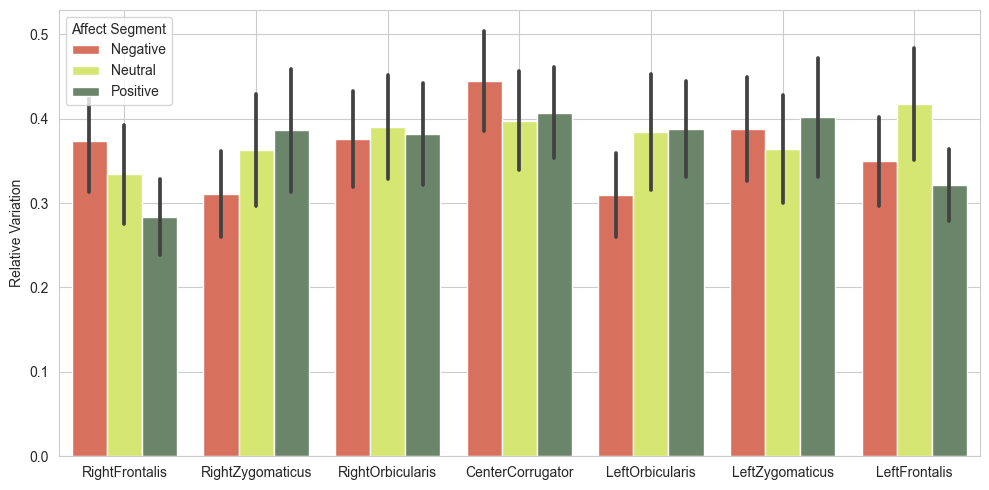

In [90]:
### Generate path to save and figure
save_path_plot = gen_path_plot(f"desc-barplot-emgContact")

NUM_ROWS = 1
NUM_COLS = 1
fig,axes = plt.subplots(NUM_ROWS, NUM_COLS, sharex=False, sharey=True, figsize=(10*NUM_COLS, 5*NUM_ROWS))

ax = axes
ax_i = plot_df_features_barplot(df_subset_features, ax=ax, errorbar='se')
# ax_i.get_legend().remove()
ax.grid(True)
ax.set(xlabel=None)
# ax.tick_params(axis='x', labelrotation = 45)

plt.tight_layout()
plt.savefig(save_path_plot)

In [91]:
contact_quality = dataset.groupby('OriginalParticipantID')['Faceplate/FitState'].agg(list)
from itertools import chain

# Extract the FitState values for each protocol
v1_participants = [101, 330]
v2_participants = [342, 384]  # Adjust the upper limit as needed

v1_values = contact_quality[contact_quality.index.isin(range(v1_participants[0], v1_participants[1] + 1))]
v2_values = contact_quality[contact_quality.index.isin(range(v2_participants[0], v2_participants[1] + 1))]

In [92]:
import pandas as pd

# Function to count values below 8 within a list
def count_values_below_8(lst):
    return sum(value < 8 for value in lst)

# Function to calculate the number of seconds below expected value
def seconds_below_expected(count_below_8, frame_duration=0.02):
    return count_below_8 * frame_duration

# Convert the Series to a DataFrame
df = contact_quality.reset_index()
df = df.rename(columns={'OriginalParticipantID': 'ParticipantID', 'Faceplate/FitState': 'FitState'})

# Define the participant ID ranges for each protocol
v1_participants = [101, 330]
v2_participants = [342, 384]

# Create a function to determine the protocol based on participant ID
def determine_protocol(participant_id):
    if v1_participants[0] <= participant_id <= v1_participants[1]:
        return 'V1 - Fully Remote'
    elif v2_participants[0] <= participant_id <= v2_participants[1]:
        return 'V2 - Lab Remote'
    else:
        return 'Unknown'

# Add a new 'Protocol' column to the DataFrame
df['Protocol'] = df['ParticipantID'].apply(determine_protocol)

# Calculate the count of values below 8 for each participant
df['CountBelow8'] = df['FitState'].apply(count_values_below_8)

# Calculate the number of seconds below expected value for each participant
df['SecondsBelowExpected'] = df['CountBelow8'] * 0.02

# Function to calculate the mean of FitState values for each participant
def mean_fitstate(lst):
    return sum(lst) / len(lst)

# Calculate the mean FitState value for each participant
df['MeanFitState'] = df['FitState'].apply(mean_fitstate)
df = df.drop(columns=['FitState'])
# Display the DataFrame
print(df)


    ParticipantID           Protocol  CountBelow8  SecondsBelowExpected  \
0             101  V1 - Fully Remote          210                  4.20   
1             216  V1 - Fully Remote          208                  4.16   
2             219  V1 - Fully Remote           41                  0.82   
3             222  V1 - Fully Remote          295                  5.90   
4             247  V1 - Fully Remote          754                 15.08   
5             248  V1 - Fully Remote          189                  3.78   
6             268  V1 - Fully Remote        11293                225.86   
7             270  V1 - Fully Remote          147                  2.94   
8             278  V1 - Fully Remote        14831                296.62   
9             290  V1 - Fully Remote          234                  4.68   
10            293  V1 - Fully Remote           93                  1.86   
11            299  V1 - Fully Remote          112                  2.24   
12            307  V1 - F

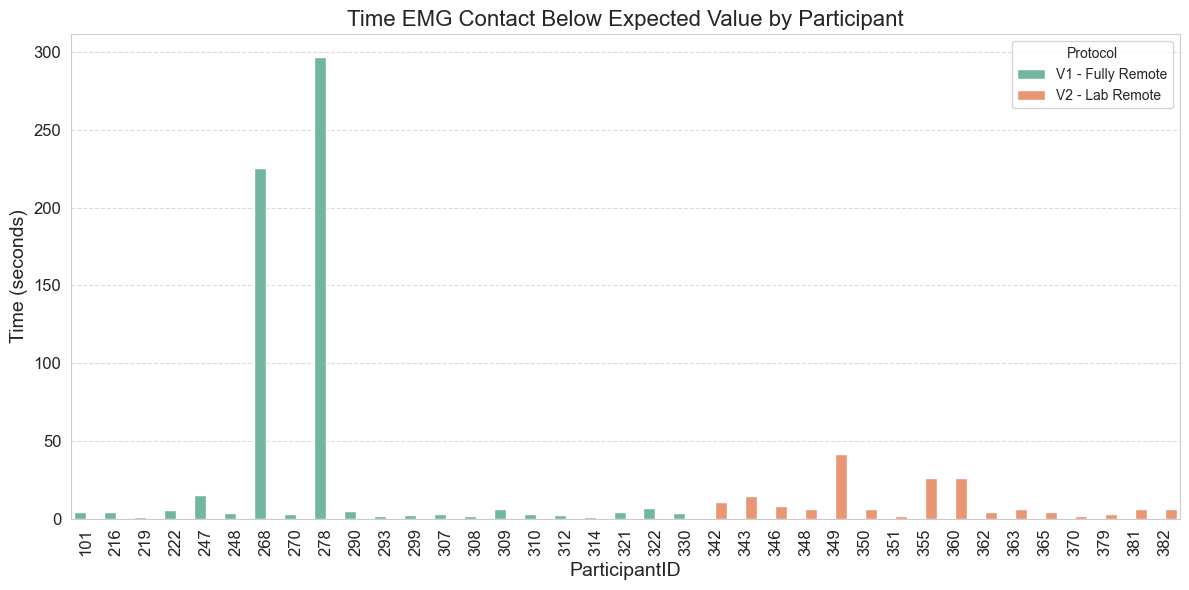

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

variable_to_plot = 'bad_contact_percentage'

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='ParticipantID', y=variable_to_plot, hue='Protocol', data=df, palette='Set2')

# Highlight the differences
for index, row in df.iterrows():
    if row['Protocol'] == 'V1 - Fully Remote':
        v2_row = df[(df['ParticipantID'] == row['ParticipantID']) & (df['Protocol'] == 'v2')]
        if not v2_row.empty and row[variable_to_plot] > v2_row[variable_to_plot].values[0]:
            plt.bar(index, row[variable_to_plot], color='r', alpha=0.7)

plt.xlabel('ParticipantID', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.title('Percentage of Overall Duration EMG Quality Below Expected Value by Participant', fontsize=16)
plt.legend(title='Protocol')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Rotate the x-axis labels vertically
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

save_path_plot = gen_path_plot(f"desc-barplot-emgContact-percentage")

plt.tight_layout()
plt.savefig(save_path_plot)

plt.show()


In [94]:
# Assuming your DataFrame is named 'result_df'
#participants_to_remove = [268, 278]
participants_to_remove = [369, 384]

#participants_to_remove = [268, 278, 369, 384]

# Filter the DataFrame to exclude the specified ParticipantID values
df = df[~df['ParticipantID'].isin(participants_to_remove)]
df

,ParticipantID,Protocol,CountBelow8,SecondsBelowExpected,MeanFitState
0,101,V1 - Fully Remote,210,4.20,8.966804
1,216,V1 - Fully Remote,208,4.16,8.970192
2,219,V1 - Fully Remote,41,0.82,8.989937
3,222,V1 - Fully Remote,295,5.90,8.956040
4,247,V1 - Fully Remote,754,15.08,8.926322
5,248,V1 - Fully Remote,189,3.78,8.969483
6,268,V1 - Fully Remote,11293,225.86,8.265007
7,270,V1 - Fully Remote,147,2.94,8.976343
8,278,V1 - Fully Remote,14831,296.62,8.036246
9,290,V1 - Fully Remote,234,4.68,8.963615


In [95]:
from scipy import stats

# Extract the data for the test
data = df['SecondsBelowExpected']

# Perform the Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(data)

# Define a significance level (alpha)
alpha = 0.05

# Check the p-value against the significance level
if shapiro_p > alpha:
    print("The data appears to be normally distributed (p-value =", shapiro_p, ")")
else:
    print("The data does not appear to be normally distributed (p-value =", shapiro_p, ")")


The data does not appear to be normally distributed (p-value = 9.01078604093053e-12 )


In [96]:
# Separate the data into two groups based on the 'Protocol' column
v1_data = df[df['Protocol'] == 'V1 - Fully Remote']['MeanFitState']
v2_data = df[df['Protocol'] == 'V2 - Lab Remote']['MeanFitState']

# Perform the Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(v1_data, v2_data, alternative='two-sided')

# Calculate the difference in means
mean_diff = v1_data.mean() - v2_data.mean()

# Define a significance level (alpha)
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print(f"There is a significant difference between v1 and v2 protocols. {abs(mean_diff)} difference.")
    if mean_diff > 0:
        print("v1 protocol is better.")
    else:
        print("v2 protocol is better.")
else:
    print("There is no significant difference between v1 and v2 protocols.")

# Print the U statistic and p-value
print(f"Mann-Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")

There is no significant difference between v1 and v2 protocols.
Mann-Whitney U statistic: 231.0
P-value: 0.05535740349718896


In [97]:
# Calculate the total seconds below expected value for each protocol
total_seconds_v1 = df[df['Protocol'] == 'V1 - Fully Remote']['SecondsBelowExpected'].sum()
total_seconds_v2 = df[df['Protocol'] == 'V2 - Lab Remote']['SecondsBelowExpected'].sum()

# Compare and print the results
if total_seconds_v1 < total_seconds_v2:
    print("Protocol v1 had fewer seconds below expected value.")
elif total_seconds_v2 < total_seconds_v1:
    print("Protocol v2 had fewer seconds below expected value.")
else:
    print("Both protocols had the same total seconds below expected value.")

Protocol v2 had fewer seconds below expected value.


---
## Analysis 3: Valence and Arousal Classification from Physiological Signals

Available in the notebook `3_ml_classification.ipynb`